## 뉴스 주제 분류 분석

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Twitter
import lightgbm as lgb
import requests
import pandas as pd 
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
def news_data_setting():
    News = pd.read_csv("인공지능 관련 뉴스메타데이터(2013.01.01-2017.08.31).CSV", encoding="cp949")
    
    spl = []
    for x in range(len(News)):
        spla = ",".join(list(set(News['키워드'][x].split(","))))
        spl.append(spla)
    News['키워드정리'] = spl
    
    News = News.filter(items=["제목","통합 분류1","본문","특성추출","키워드정리"])
    News = News[News['통합 분류1'].notna()]
    
    News['통합 분류1'] = News['통합 분류1'].replace("경제>국제경제", "경제>경경")
    
    IT = News[News['통합 분류1'].str.contains("IT_과학>")]
    eco = News[News['통합 분류1'].str.contains("경제")]
    spo = News[News['통합 분류1'].str.contains("스포츠>")]
    wol = News[News['통합 분류1'].str.contains("국제")]
    con = News[News['통합 분류1'].str.contains("지역>")]
    so = News[News['통합 분류1'].str.contains("사회")]
    book = News[News['통합 분류1'].str.contains("문화")]
    soc = News[News['통합 분류1'].str.contains("정치")]
    
    IT['class'] = "과학"
    IT['category'] = 1

    eco['class'] = "경제"
    eco['category'] = 2

    spo['class'] = "스포츠"
    spo['category'] = 3

    wol['class'] = "국제"
    wol['category'] = 4

    con['class'] = "지역"
    con['category'] = 5

    so['class'] = "사회"
    so['category'] = 6

    book['class'] = "문화"
    book['category'] = 7

    soc['class'] = "정치"
    soc['category'] = 8
    
    total = pd.concat([IT,eco,spo,wol,con,so,book,soc]).reset_index(drop=True)
    
    return total

total = news_data_setting()

In [3]:
total.tail()

,제목,통합 분류1,본문,특성추출,키워드정리,class,category
45370,일자리·4차 산업혁명·교육…위원회는 `文정부 거울`,정치>청와대,◆ 레이더뉴스 / 文정부 위원회 大해부 ◆ 문재인 대통령이 국정 5개년 계획을 차...,"위원회,청와대,4차,위원장,다음달,일자리,저출산,문재인,북방경제협력위원회,대타협,광...","보완,상설,대외경제회의,중등,처리,해부,문재인,완성,주문,변경,시대,복원,프로젝트,...",정치,8
45371,"냉랭한 한일관계, 어떻게 풀어지려나",정치>외교,"우리는 지난 15일 광복 72주년을 보내고, 이제 29일 경술국치일을 맞는다. ...","일본,한일관계,한국,한일,고노,양국간,위안부,문재인,선린,백제,관광객,한국사회,주력...","타격,문재인,정권,한일관계,애니메이션,경제안보문제,발전,미래,8.15,인재,상대,한...",정치,8
45372,문 대통령 “설계수명 다한 노후원전 연장가동 안한다”,정치>외교,문재인 대통령이 “원전과 화력발전을 줄이고 안전한 미래에너지를 늘려야 한다”고 거듭...,"미국,자유무역협정,중국,기업인,발전소,위원장,사드,경제협력,지방자치단체,신재생,7기...","연방하원,무역협회,호혜,그랜드인터콘티넨탈호텔,문재인,중소기업,대응,이익,산업부,경제...",정치,8
45373,[편집국에서] 사이다만 먹고 살 순 없다,정치>청와대,“공정거래위원회가 (국민들의) 막힌 곳을 뚫어주는 사이다 역할을 하고 있다.” 문재...,"한국,세월호,공정위,기간제,국민들,1류,저성장,가처분,박일근,3류,빅데이터,4차,운...","근본적,분배,공정거래위원회,문재인,의미,독일,순직,운동기념식장,기간제,가난,스스로,...",정치,8
45374,“수직적 권력분산 위해 자치분권 실현 중요”,정치,정순관 대통령소속 지방자치발전위원장은 29일 “자치분권은 시대적 흐름에 부응하는 핵...,"위원장,지방분권,정순관,4차,제2국무회의,지방세,권력분산,수직적,지방이양,인공지능,...","비율,마을,자치,의미,대응,연방제,발전,부응,자치재정권,사물인터넷,4차,국민들,해소...",정치,8


In [29]:
total['class'].value_counts()

과학     21397
경제     12887
문화      4934
사회      1752
국제      1646
정치      1159
지역      1093
스포츠      507
Name: class, dtype: int64

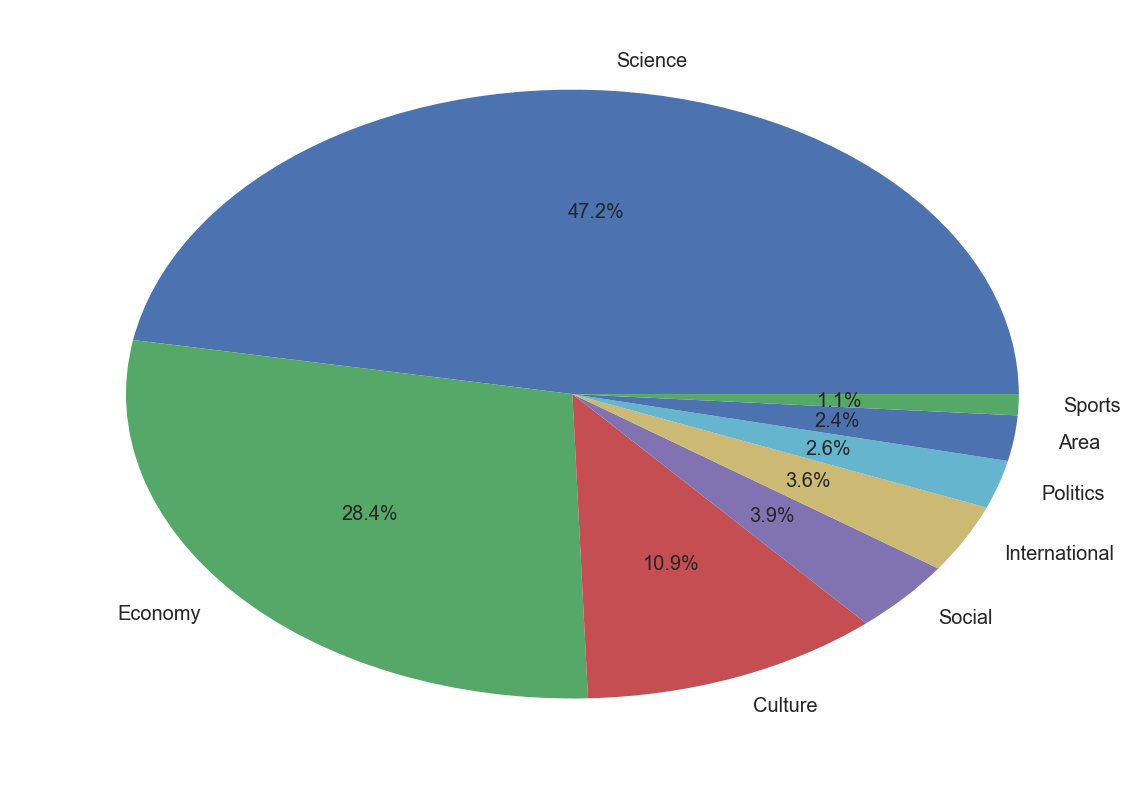

In [123]:
total_v = total['class'].value_counts()
fig = plt.figure(figsize = (10,7))
labels = ['Science','Economy','Culture','Social','International','Politics','Area','Sports',]
plt.pie(total_v, labels=labels ,autopct='%1.1f%%')
plt.show()

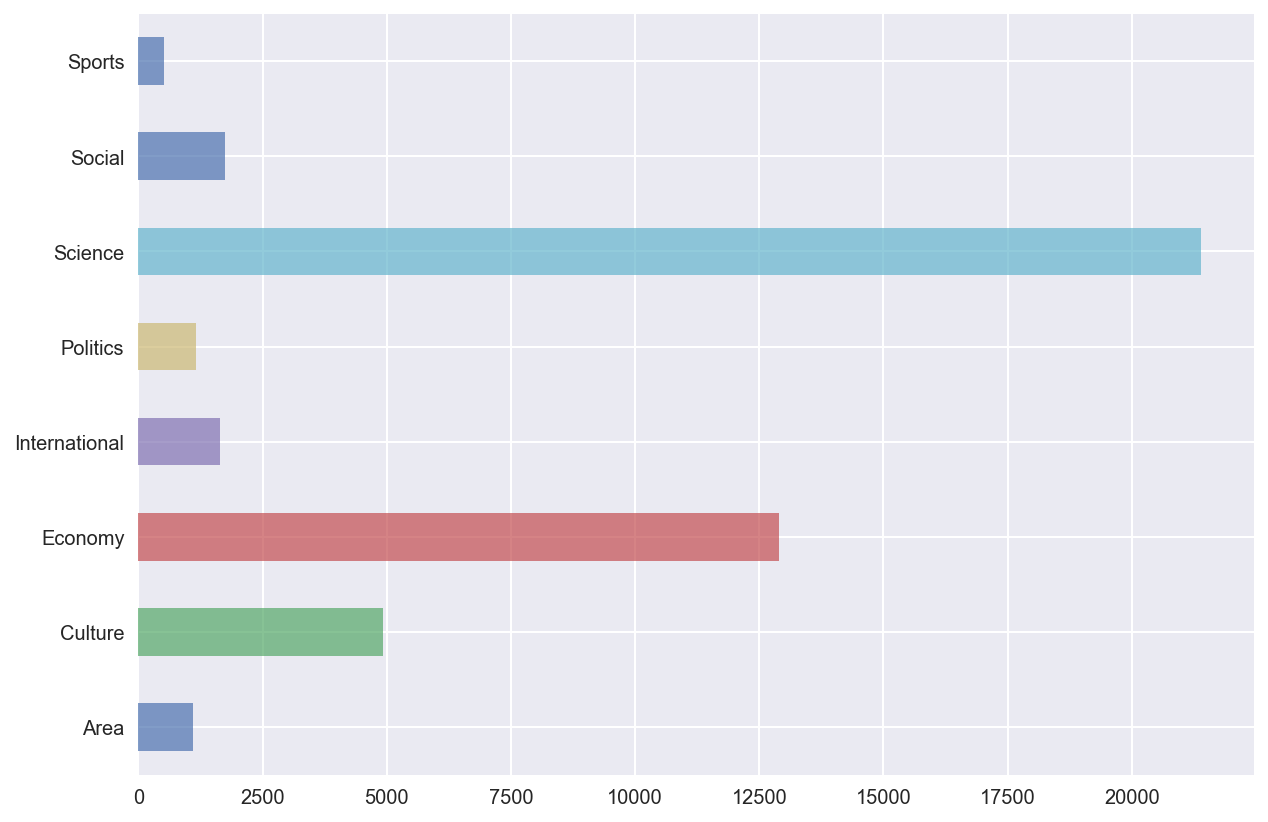

In [132]:
total_v_s = pd.Series({'Science':21397,'Economy':12887,'Culture':4934,'Social':1752,
                       'International':1646,'Politics':1159,'Area':1093,'Sports':507})
fig = plt.figure(figsize = (10,7))
total_v_s.plot(kind="barh", align='center', alpha=0.7)
plt.show()

---

### news 제목

In [4]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [5]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,1))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [6]:
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(total['제목'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_a),len(X_test_a),len(y_train_a),len(y_test_a)

(27225, 18150, 27225, 18150)

Train 

Train confusion_matrix 

[[11991   621    18    53    21    22   190    12]
 [ 1423  6138     2    16    24     5    31    20]
 [   25     1   242     9     0     0    15     0]
 [  171    56     5   713     0     2    19    10]
 [  119    46     1     1   467     3    11     2]
 [  191    29     2     2     6   809    32     9]
 [  386    41    19    12     5    17  2464     2]
 [   57    21     0     3     3     0     1   609]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.83      0.93      0.88     12928
          2       0.88      0.80      0.84      7659
          3       0.84      0.83      0.83       292
          4       0.88      0.73      0.80       976
          5       0.89      0.72      0.79       650
          6       0.94      0.75      0.83      1080
          7       0.89      0.84      0.86      2946
          8       0.92      0.88      0.90       694

avg / total       0.86      0.86      0.86    

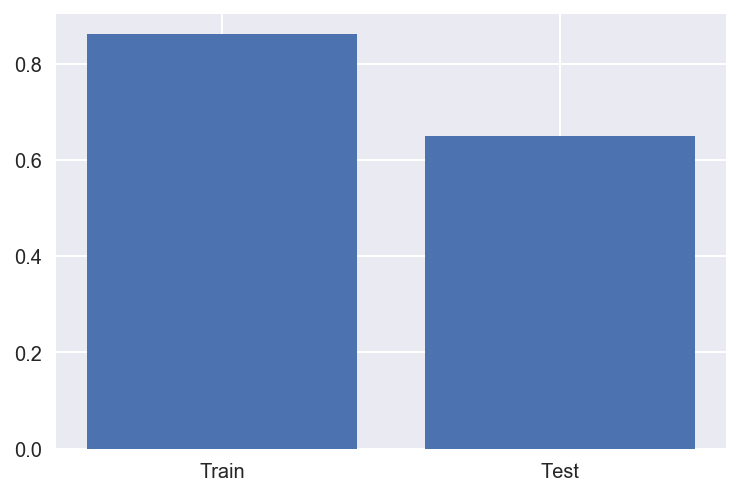

In [7]:
# def news_name():
model_a = clf.fit(X_train_a, y_train_a)

y_pred_a = model_a.predict(X_train_a)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_a, y_pred_a), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_a, y_pred_a), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_a, y_pred_a), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_a_T = model_a.predict(X_test_a)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_a, y_pred_a_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_a, y_pred_a_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_a, y_pred_a_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_a, y_pred_a), accuracy_score(y_test_a, y_pred_a_T)
plt.bar(x,y)
plt.show()

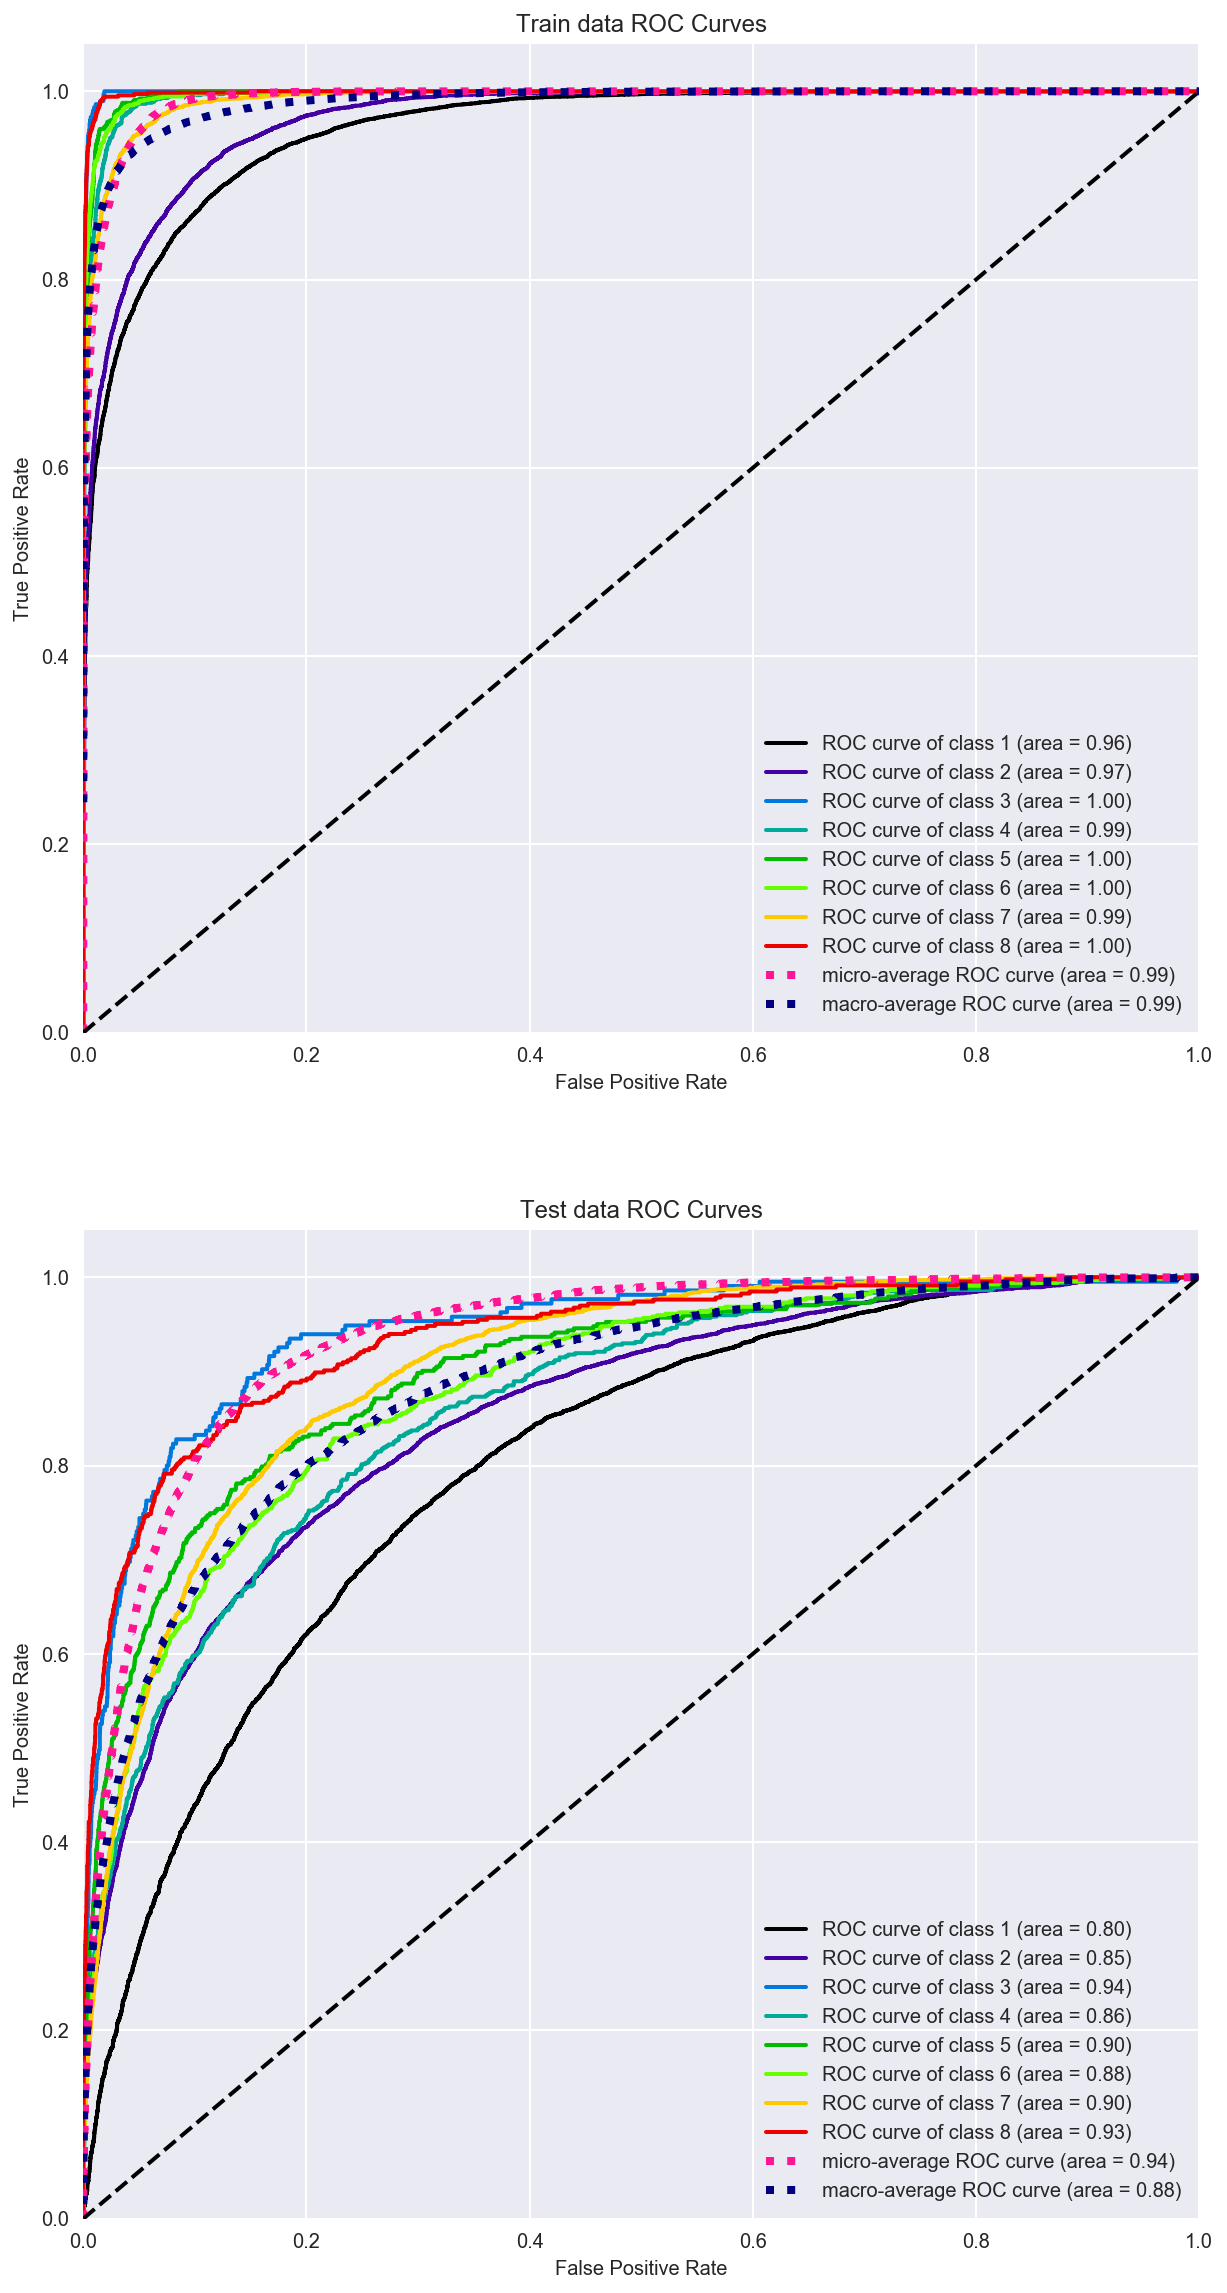

In [8]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_a.predict_proba(X_train_a)
y_probas_T = model_a.predict_proba(X_test_a)

skplt.metrics.plot_roc_curve(y_train_a, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_a, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### news 특성추출

In [9]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [10]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,1))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [11]:
X_train_cha, X_test_cha, y_train_cha, y_test_cha = train_test_split(total['특성추출'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_cha),len(X_test_cha),len(y_train_cha),len(y_test_cha)

(27225, 18150, 27225, 18150)

Train 

Train confusion_matrix 

[[11925   624    43    65    49    61   149    12]
 [ 1169  6378     6    11    43    14    20    18]
 [    7     1   272     8     1     0     3     0]
 [   97    50    13   799     0     2     7     8]
 [   45    26     2     3   559     4     8     3]
 [   93    29     9     7     6   918    15     3]
 [  239    29    27    18     8    22  2601     2]
 [   28    15     1     1     3     0     2   644]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.88      0.92      0.90     12928
          2       0.89      0.83      0.86      7659
          3       0.73      0.93      0.82       292
          4       0.88      0.82      0.85       976
          5       0.84      0.86      0.85       650
          6       0.90      0.85      0.87      1080
          7       0.93      0.88      0.90      2946
          8       0.93      0.93      0.93       694

avg / total       0.89      0.89      0.88    

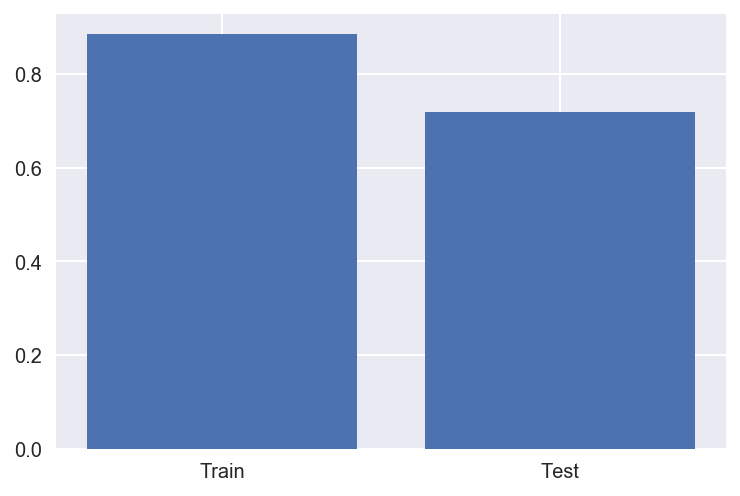

In [12]:
# def news_cha():
model_cha = clf.fit(X_train_cha, y_train_cha)

y_pred_cha = model_cha.predict(X_train_cha)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_cha, y_pred_cha), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_cha, y_pred_cha), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_cha, y_pred_cha), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_cha_T = model_cha.predict(X_test_cha)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_cha, y_pred_cha_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_cha, y_pred_cha_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_cha, y_pred_cha_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_cha, y_pred_cha), accuracy_score(y_test_cha, y_pred_cha_T)
plt.bar(x,y)
plt.show()

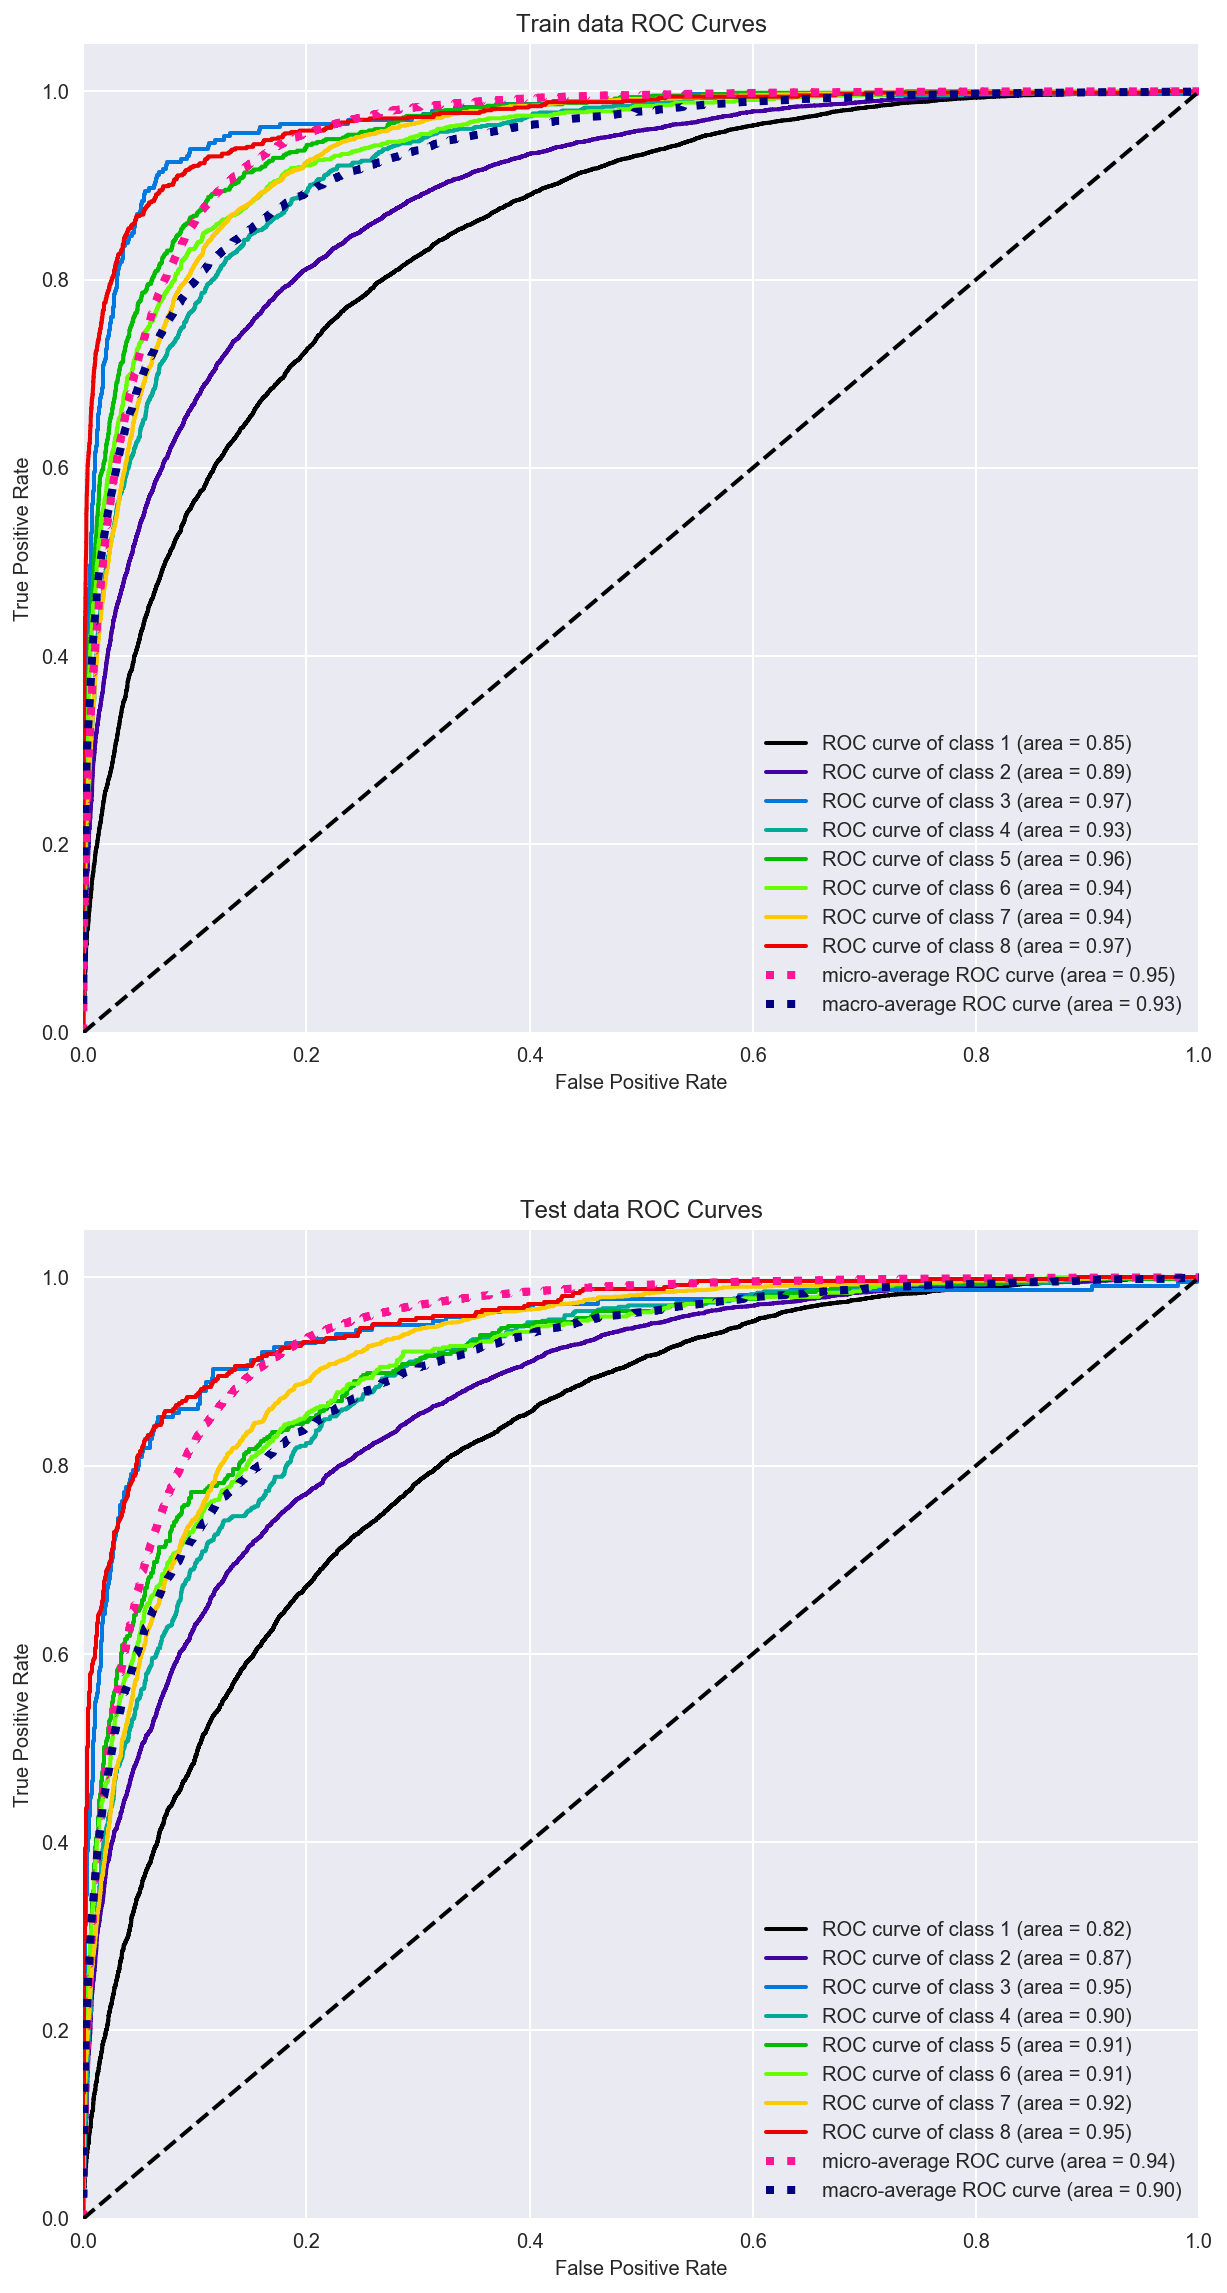

In [13]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_a.predict_proba(X_train_cha)
y_probas_T = model_a.predict_proba(X_test_cha)

skplt.metrics.plot_roc_curve(y_train_cha, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_cha, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### news 본문

In [14]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [15]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,2))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [16]:
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(total['본문'], total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train_F),len(X_test_F),len(y_train_F),len(y_test_F)

(40837, 4538, 40837, 4538)

Train 

Train confusion_matrix 

[[18613   235    36    77    50    39   169     8]
 [  162 11371     6    12    30    10    32    14]
 [    1     2   454     3     0     0     1     0]
 [    8    11     1  1456     0     2     2     3]
 [    7     4     2     2   943     1     9     1]
 [    3     7     4     2     6  1551     5     2]
 [   33    10     9    10     8     7  4382     2]
 [    3     2     0     0     1     0     0  1013]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.99      0.97      0.98     19227
          2       0.98      0.98      0.98     11637
          3       0.89      0.98      0.93       461
          4       0.93      0.98      0.96      1483
          5       0.91      0.97      0.94       969
          6       0.96      0.98      0.97      1580
          7       0.95      0.98      0.97      4461
          8       0.97      0.99      0.98      1019

avg / total       0.97      0.97      0.97    

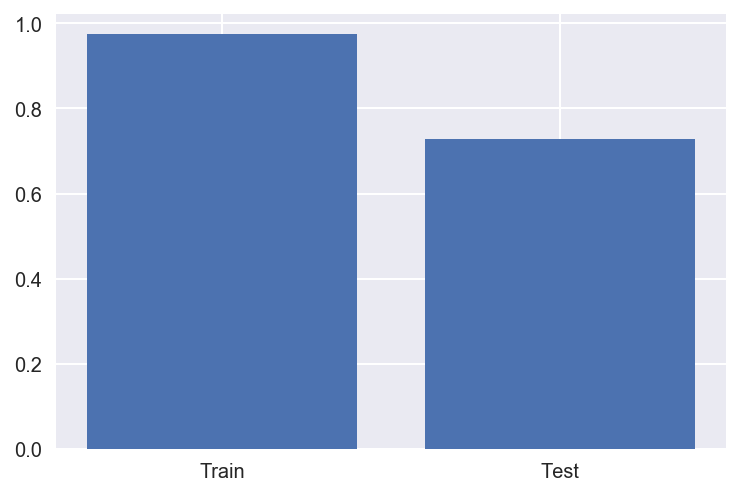

In [17]:
# def news_con():
model_F = clf.fit(X_train_F, y_train_F)

y_pred_F = model_F.predict(X_train_F)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_F, y_pred_F), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_F, y_pred_F), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_F, y_pred_F), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_F_T = model_F.predict(X_test_F)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_F, y_pred_F_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_F, y_pred_F_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_F, y_pred_F_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_F, y_pred_F), accuracy_score(y_test_F, y_pred_F_T)
plt.bar(x,y)
plt.show()

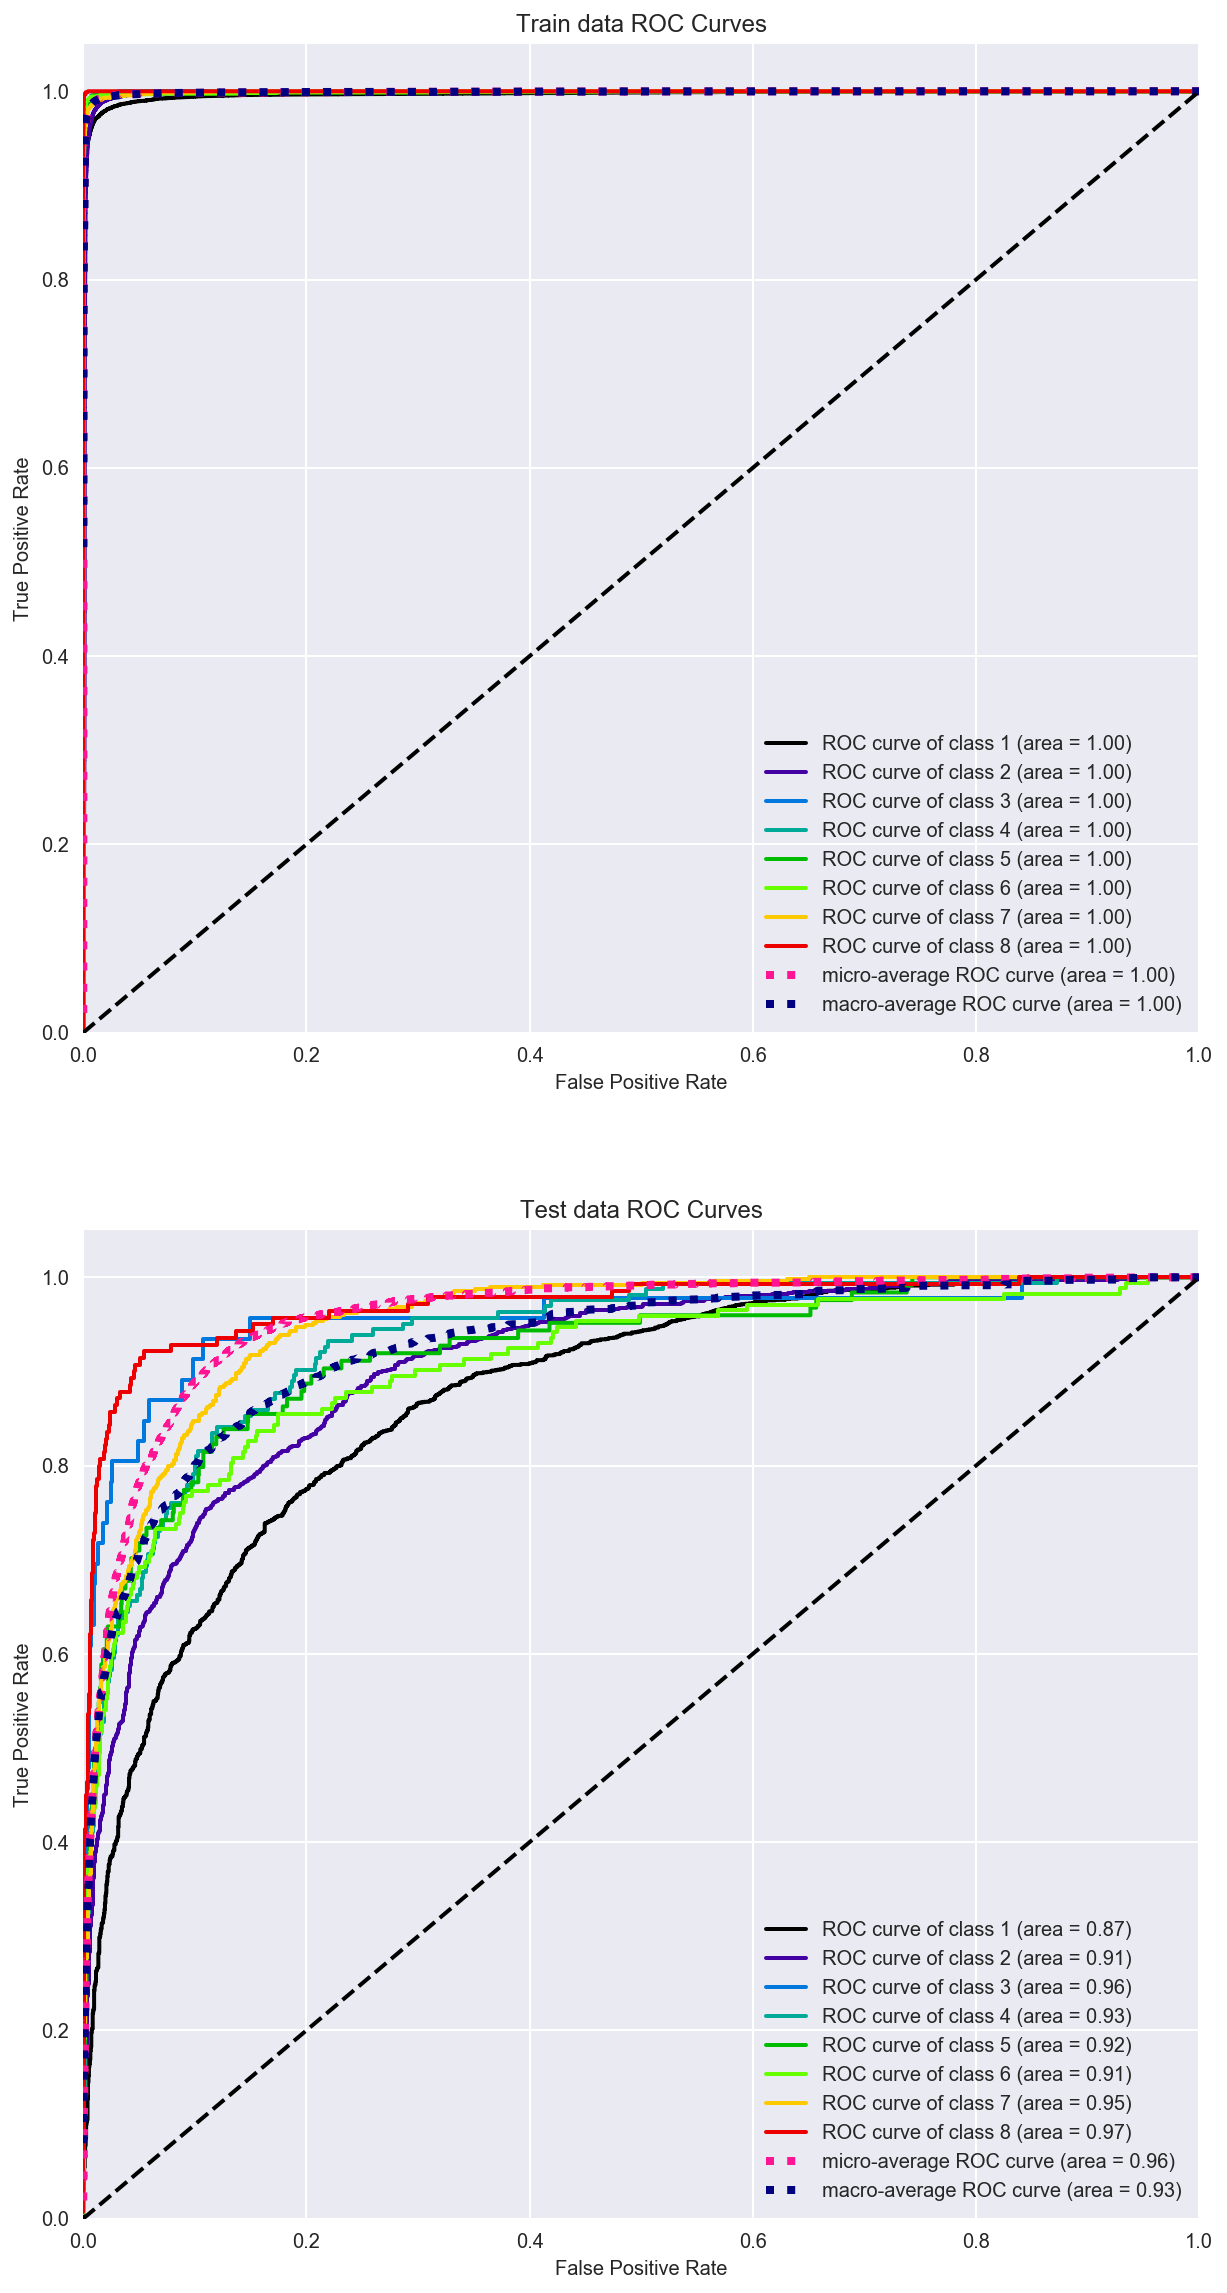

In [18]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_F.predict_proba(X_train_F)
y_probas_T = model_F.predict_proba(X_test_F)

skplt.metrics.plot_roc_curve(y_train_F, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_F, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### news 키워드

In [6]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [7]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos, ngram_range=(1,1))), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [9]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(total['키워드정리'], total['category'], \
                                                    test_size=0.4, random_state=0)

len(X_train_k),len(X_test_k),len(y_train_k),len(y_test_k)

(27225, 18150, 27225, 18150)

Train 

Train confusion_matrix 

[[12098   532    13    45     8    16   211     5]
 [ 1934  5678     2     5    14     5    16     5]
 [   42     3   215     9     2     1    20     0]
 [  221   121    12   589     0     1    25     7]
 [  150    59     1     2   414     6    15     3]
 [  244    42     5     7     4   739    34     5]
 [  477    28    14    14     4    19  2389     1]
 [   92    50     1     2     4     0     2   543]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.79      0.94      0.86     12928
          2       0.87      0.74      0.80      7659
          3       0.82      0.74      0.77       292
          4       0.88      0.60      0.71       976
          5       0.92      0.64      0.75       650
          6       0.94      0.68      0.79      1080
          7       0.88      0.81      0.84      2946
          8       0.95      0.78      0.86       694

avg / total       0.84      0.83      0.83    

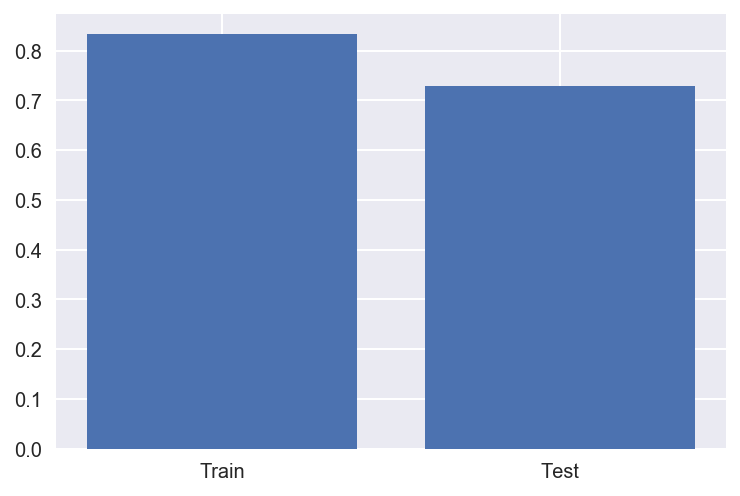

In [10]:
# def news_keyeword():
model_k = clf.fit(X_train_k, y_train_k)

y_pred_k = model_k.predict(X_train_k)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train_k, y_pred_k), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train_k, y_pred_k), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train_k, y_pred_k), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_k_T = model_k.predict(X_test_k)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test_k, y_pred_k_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test_k, y_pred_k_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test_k, y_pred_k_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train_k, y_pred_k), accuracy_score(y_test_k, y_pred_k_T)
plt.bar(x,y)
plt.show()

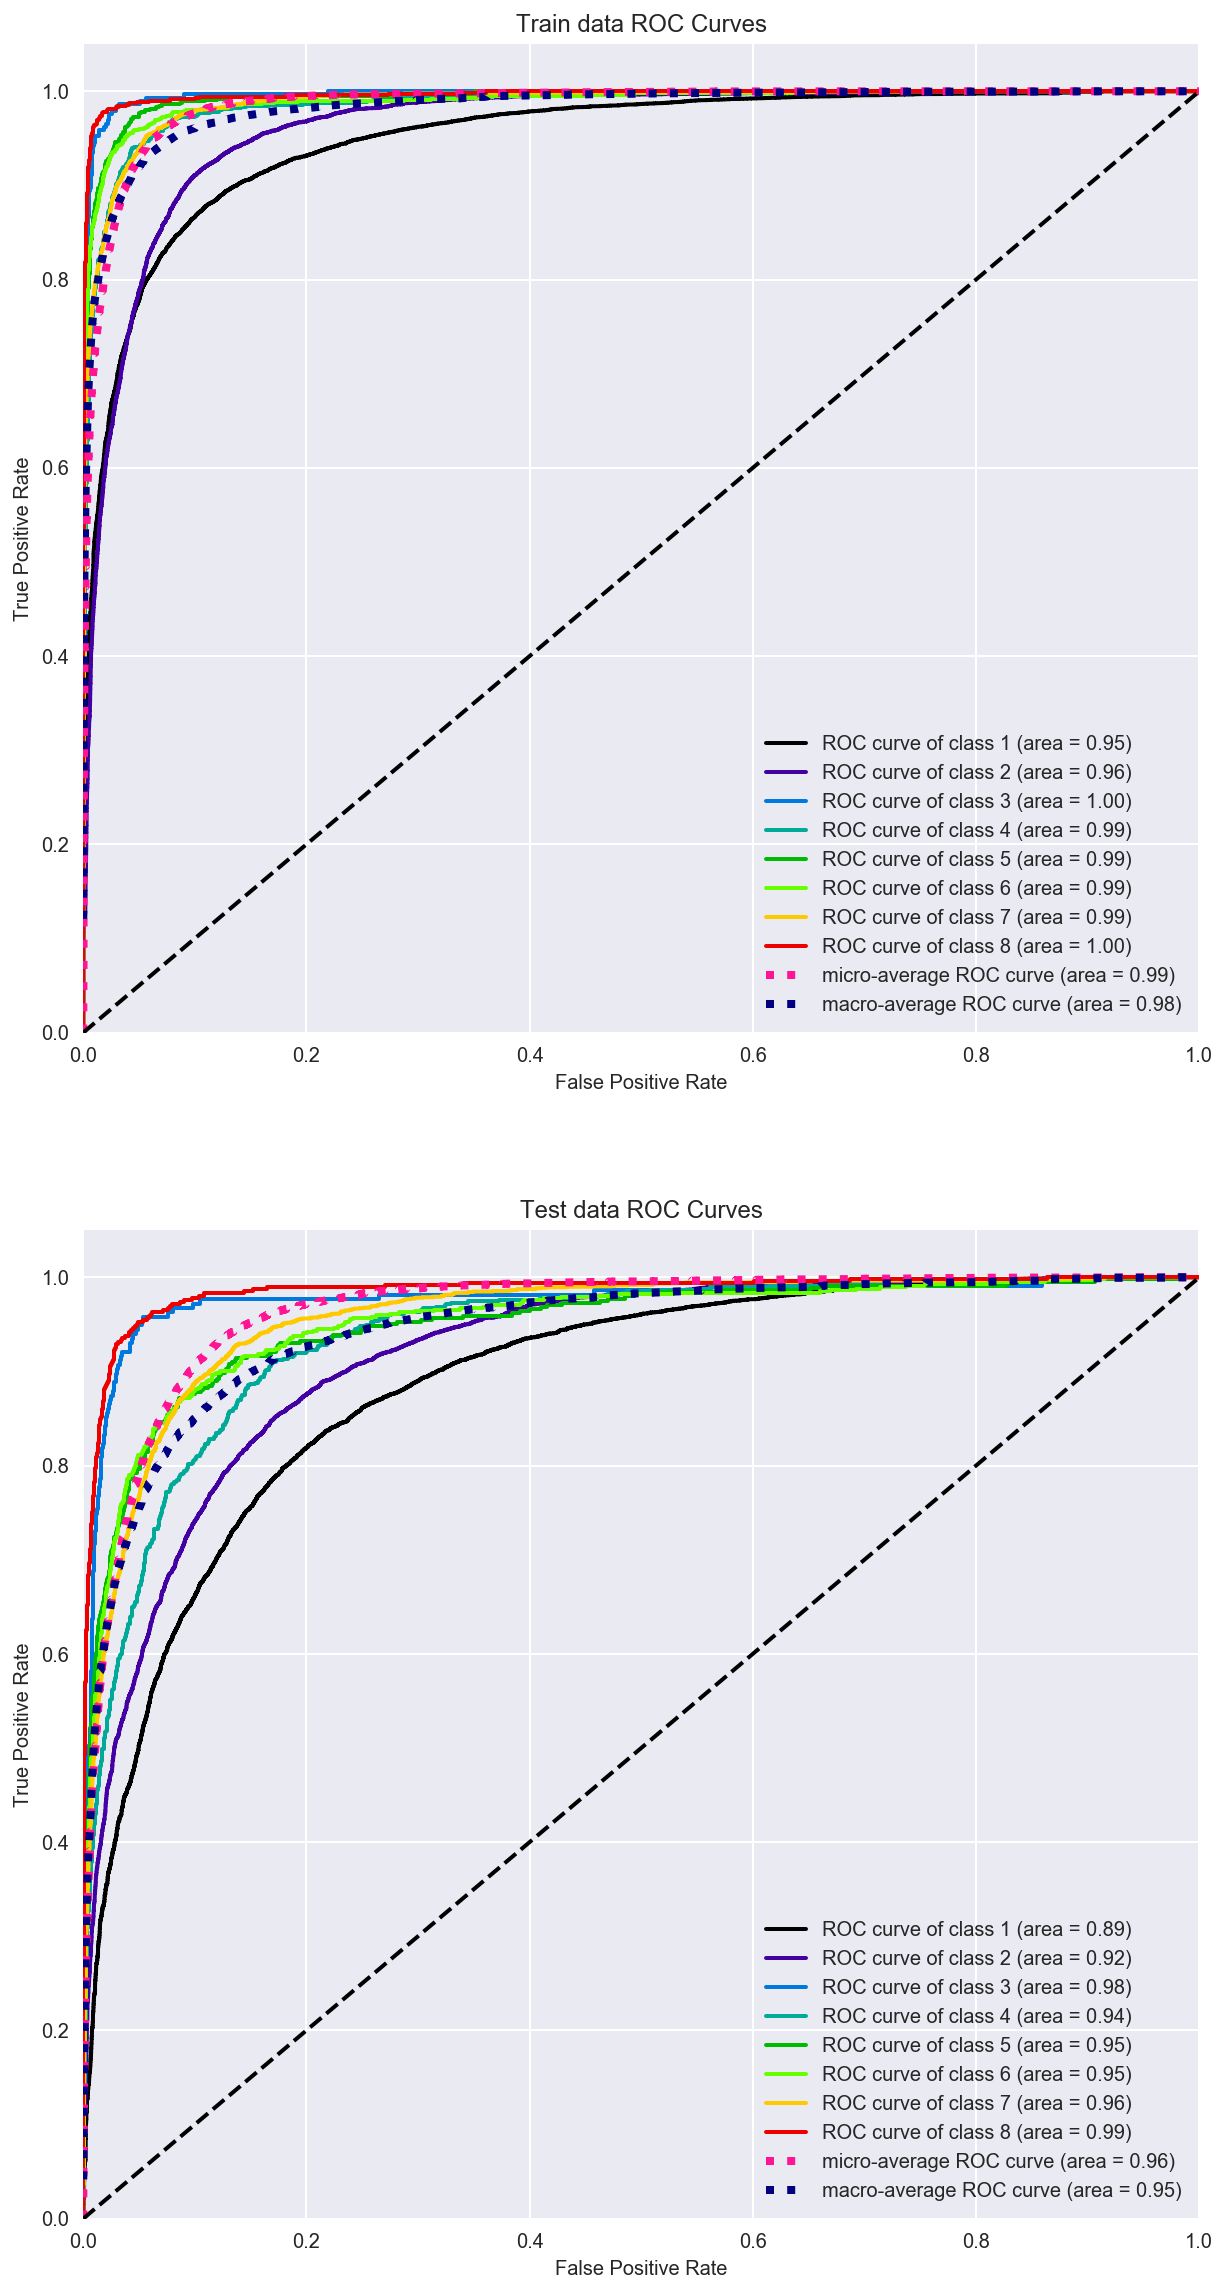

In [12]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_k.predict_proba(X_train_k)
y_probas_T = model_k.predict_proba(X_test_k)

skplt.metrics.plot_roc_curve(y_train_k, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test_k, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

---

### news 본문 + 특성추출 + 제목

In [26]:
def data_resetting():
    total_ = total.filter(items=['본문',"class",'category'])
    total_ = total_.rename(columns={"본문":"cont"})
    total__ = total.filter(items=['특성추출',"class",'category'])
    total__ = total__.rename(columns={"특성추출":"cont"})
    total___ = total.filter(items=['제목',"class",'category'])
    total___ = total___.rename(columns={"제목":"cont"})
    
    t_total = pd.concat([total_,total__,total___]).reset_index(drop=True)
    
    return t_total

t_total = data_resetting()

In [27]:
t_total.tail()

,cont,class,category
136120,일자리·4차 산업혁명·교육…위원회는 `文정부 거울`,정치,8
136121,"냉랭한 한일관계, 어떻게 풀어지려나",정치,8
136122,문 대통령 “설계수명 다한 노후원전 연장가동 안한다”,정치,8
136123,[편집국에서] 사이다만 먹고 살 순 없다,정치,8
136124,“수직적 권력분산 위해 자치분권 실현 중요”,정치,8


In [28]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [29]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos)), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(t_total['cont'], t_total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(122512, 13613, 122512, 13613)

Train 

Train confusion_matrix 

[[51684  3633   269   298   217   219  1376    98]
 [ 8156 25917    25    64   196    75   214   141]
 [  127    17  1146    35     4     0    44     1]
 [  894   423   105  2813     1    18   150    38]
 [  527   235    17     5  2079    26    68    20]
 [  992   181    39    26    58  3203   198    42]
 [ 2129   205   267    93    88   128 10371    20]
 [  348   169    10    15    17     8    47  2483]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.80      0.89      0.84     57794
          2       0.84      0.74      0.79     34788
          3       0.61      0.83      0.70      1374
          4       0.84      0.63      0.72      4442
          5       0.78      0.70      0.74      2977
          6       0.87      0.68      0.76      4739
          7       0.83      0.78      0.80     13301
          8       0.87      0.80      0.84      3097

avg / total       0.82      0.81      0.81    

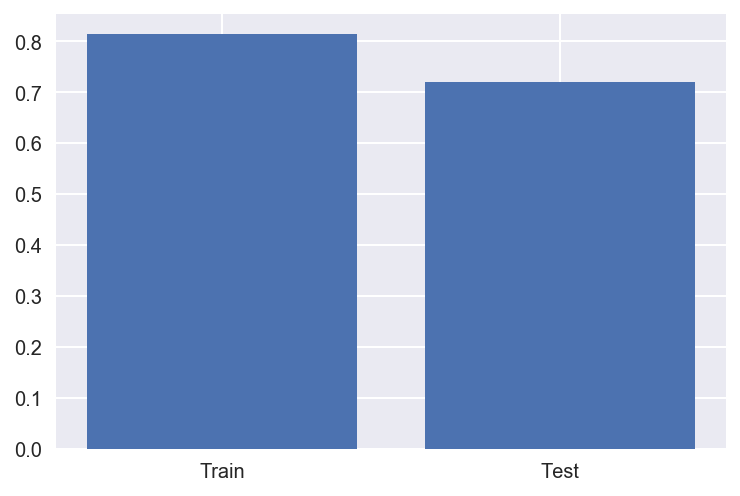

In [33]:
# def total():
model_t = clf.fit(X_train, y_train)

y_pred = model_t.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_T = model_t.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_T)
plt.bar(x,y)
plt.show()

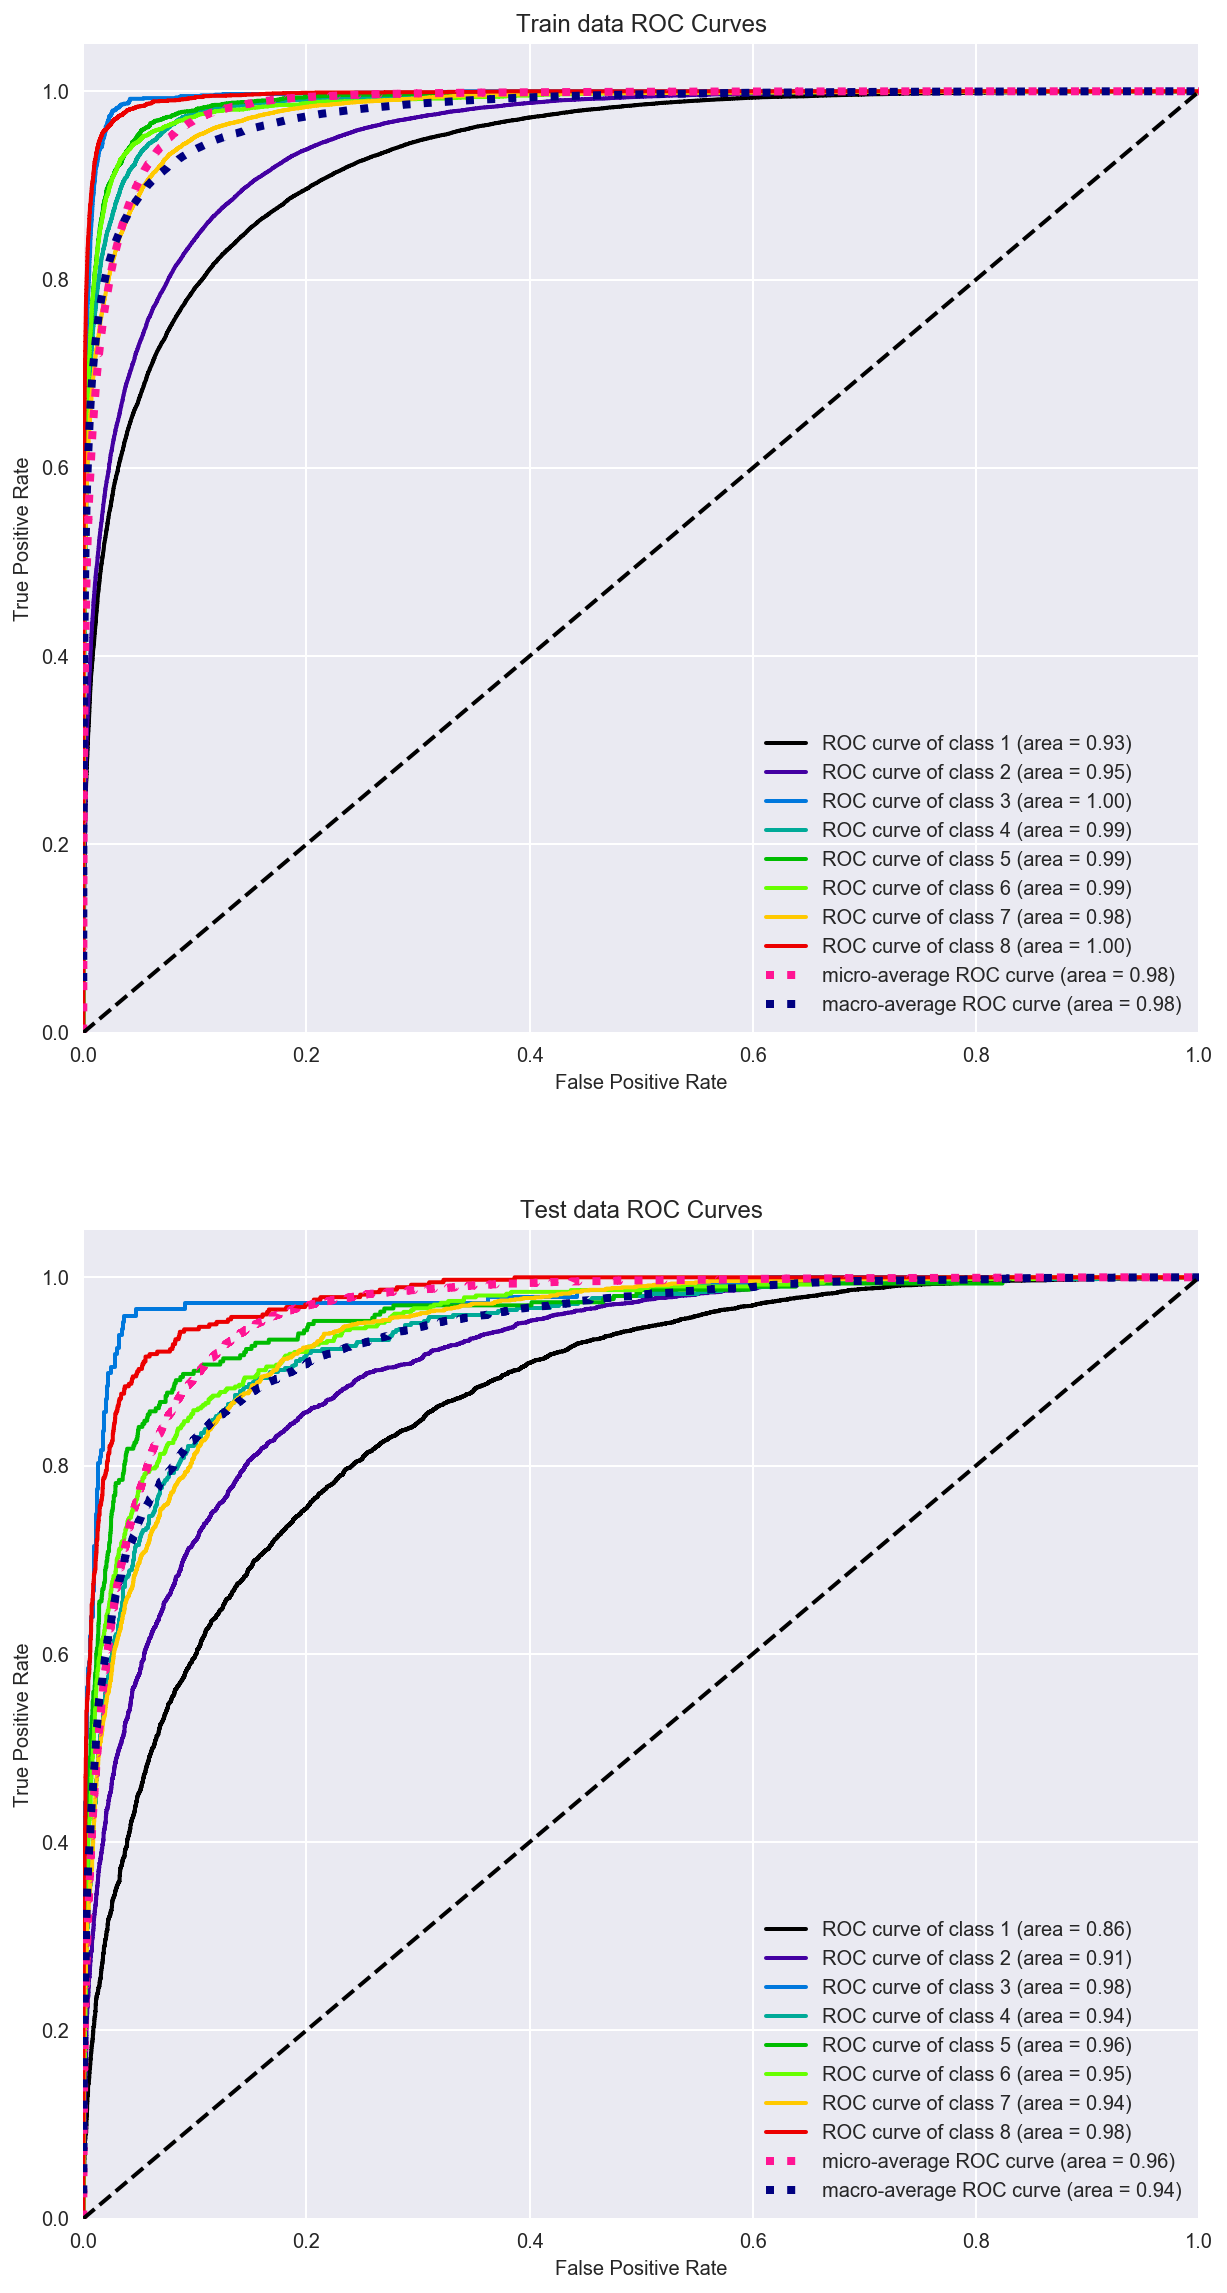

In [34]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_t.predict_proba(X_train)
y_probas_T = model_t.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test  (과학:1, 경제:2, 스포츠:3, 국제:4, 지역:5, 사회:6, 문화:7, 정치:8)

In [37]:
X_=pd.Series("개헌")

y_pred_t = model_a.predict_proba(X_)
y_pred = model_a.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.00142078 0.00139733 0.00127244 0.06951734 0.06108953 0.01926762
  0.04204247 0.80399249]]
[8]


In [32]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_a.predict_proba(X_)
y_pred = model_a.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 부동산
[[0.30173042 0.63621373 0.00165791 0.0095907  0.00423226 0.01091773
  0.02848678 0.00717046]]
[2]


---

### news 본문 + 특성추출 + 제목 + 키워드

In [17]:
def data_resetting():
    total_ = total.filter(items=['본문',"class",'category'])
    total_ = total_.rename(columns={"본문":"cont"})
    total__ = total.filter(items=['특성추출',"class",'category'])
    total__ = total__.rename(columns={"특성추출":"cont"})
    total___ = total.filter(items=['제목',"class",'category'])
    total___ = total___.rename(columns={"제목":"cont"})
    total____ = total.filter(items=['키워드정리',"class",'category'])
    total____ = total____.rename(columns={"키워드정리":"cont"})
    
    t_total = pd.concat([total_,total__,total___,total____]).reset_index(drop=True)
    
    return t_total

t_total = data_resetting()

In [18]:
t_total.tail()

,cont,class,category
181495,"자문,이양,복원,국방,인공지능,최소화,부처,안건,러시아통,예고,이달,산업,저성장,보...",정치,8
181496,"21세기,조선시대,선진문물,침입,인공지능,강세,헌법재판소,민족,남북통일운동국민연합,...",정치,8
181497,"사드,청정,사이,부처,인공지능,그랜드,사업,제3국,비중,가동,90여명,요구,LNG,...",정치,8
181498,"민주화,교사,사과,사이,박수,세월호,인공지능,저성장,취지,업무,분배,가맹,한참,정작...",정치,8
181499,"권력분산,인공지능,재정분권,요구,산업,헌법,명실상부,계기,개정,혁명,정순관,경쟁,국...",정치,8


In [19]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [20]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos)), 
    ("clf", MultinomialNB(alpha=0.01))
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(t_total['cont'], t_total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(163350, 18150, 163350, 18150)

Train 

Train confusion_matrix 

[[69687  4401   326   374   236   252  1653   108]
 [11834 33743    34    91   258    89   265   150]
 [  223    21  1468    48     4     0    59     1]
 [ 1350   639   135  3484     1    24   196    52]
 [  803   328    19     9  2636    40    94    25]
 [ 1491   252    50    38    64  4060   289    64]
 [ 3093   256   351   133   106   150 13611    22]
 [  561   253    10    17    29     8    66  3216]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.78      0.90      0.84     77037
          2       0.85      0.73      0.78     46464
          3       0.61      0.80      0.70      1824
          4       0.83      0.59      0.69      5881
          5       0.79      0.67      0.72      3954
          6       0.88      0.64      0.74      6308
          7       0.84      0.77      0.80     17722
          8       0.88      0.77      0.82      4160

avg / total       0.81      0.81      0.80    

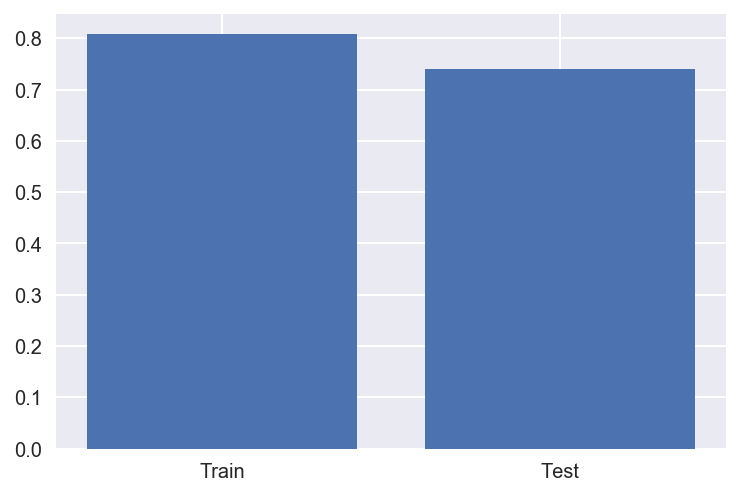

In [22]:
# def total():
model_t = clf.fit(X_train, y_train)

y_pred = model_t.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_T = model_t.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_T)
plt.bar(x,y)
plt.show()

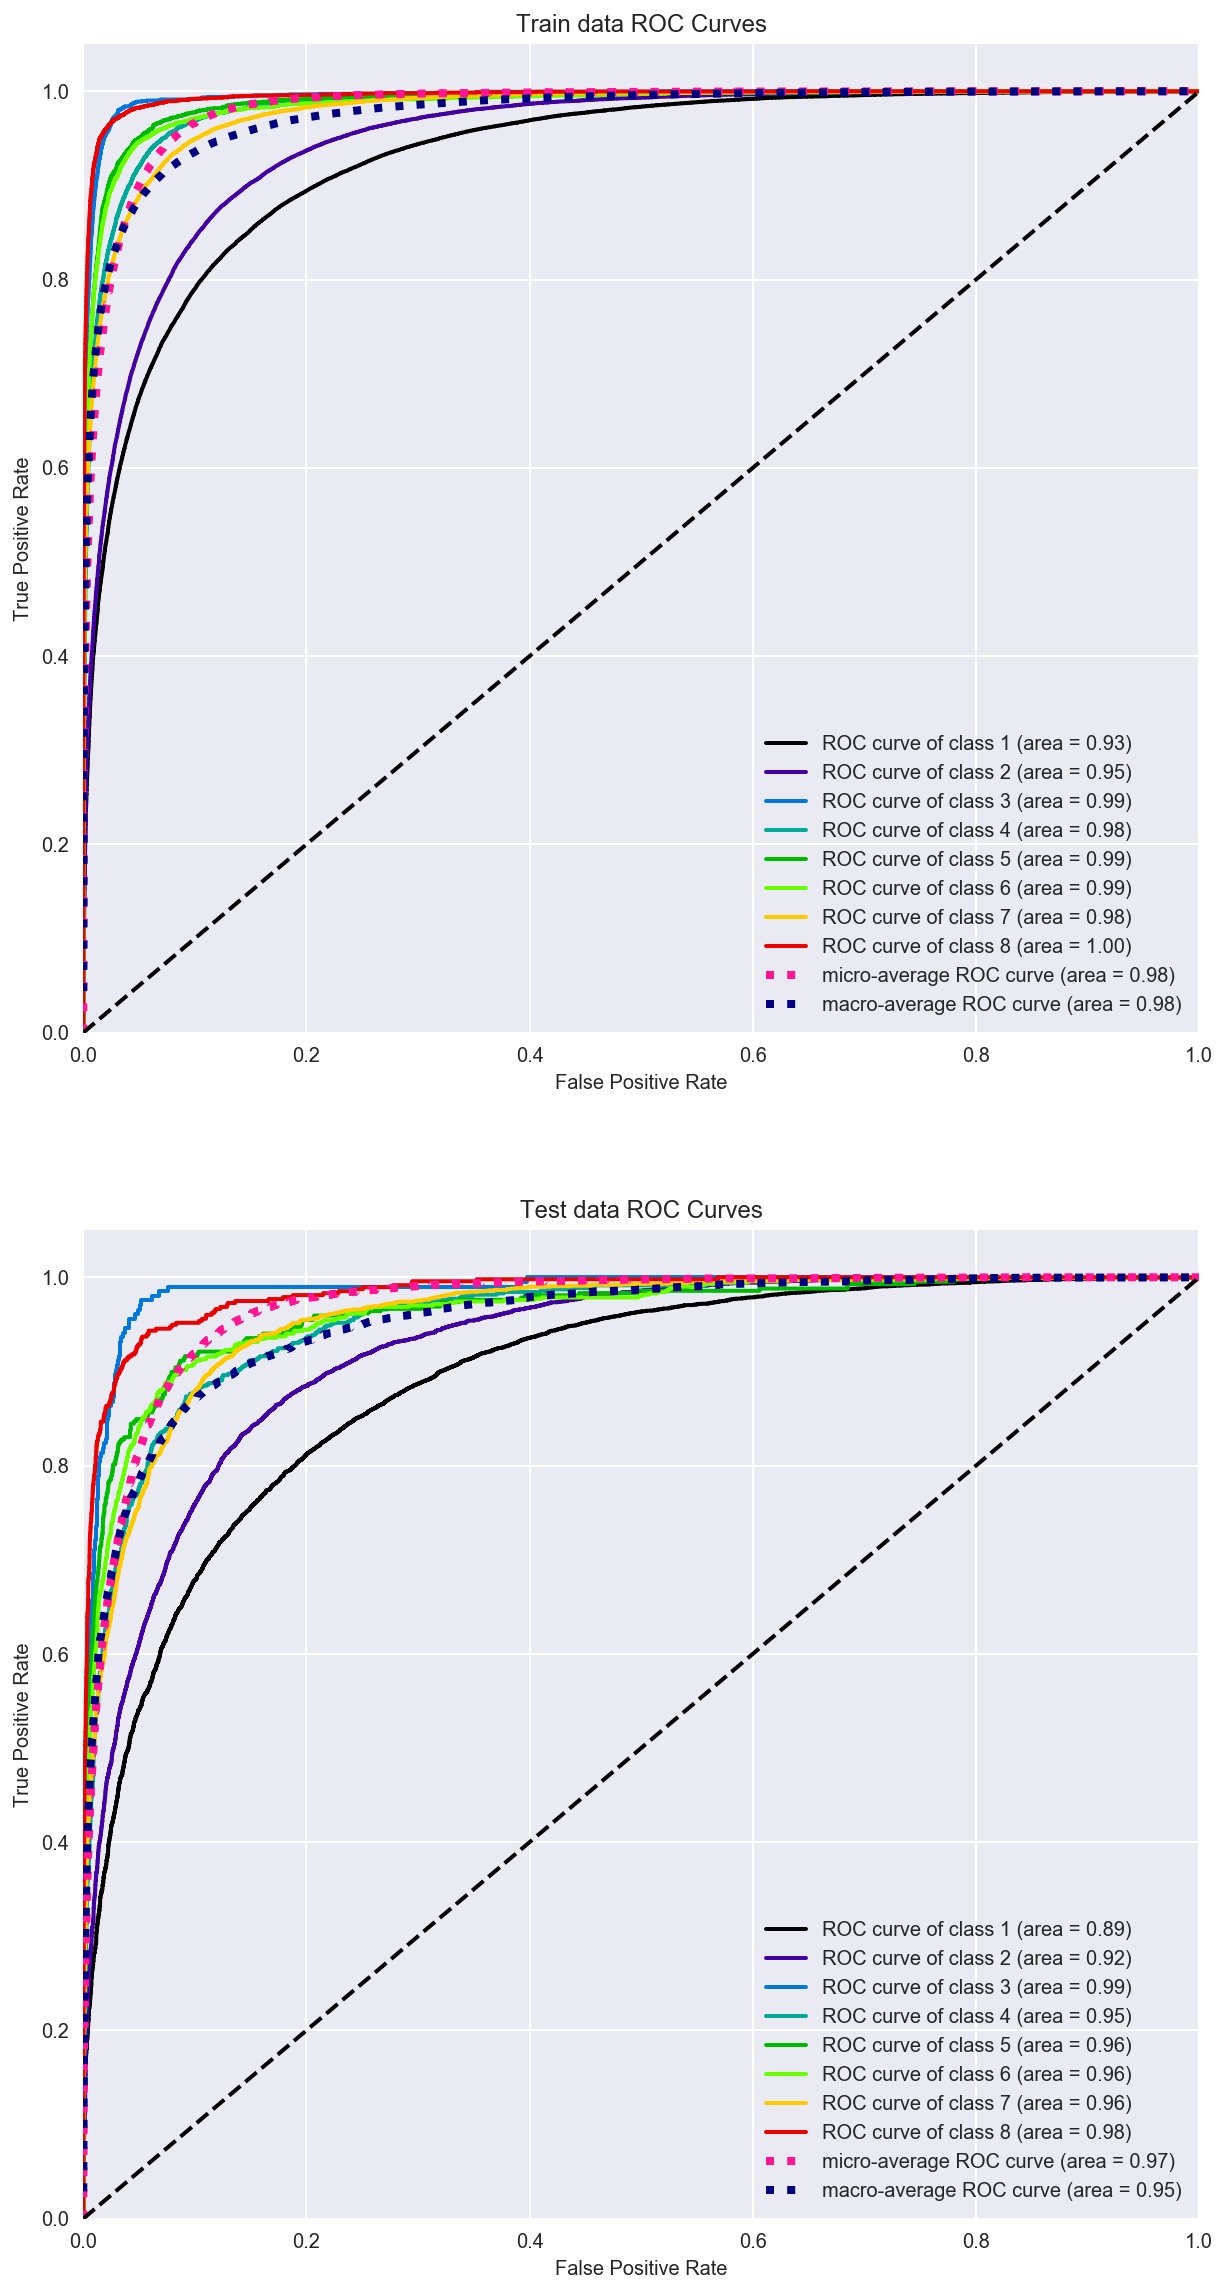

In [63]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_t.predict_proba(X_train)
y_probas_T = model_t.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test  (과학:1, 경제:2, 스포츠:3, 국제:4, 지역:5, 사회:6, 문화:7, 정치:8)

In [64]:
X_=pd.Series("개헌")

y_pred_t = model_t.predict_proba(X_)
y_pred = model_t.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.00419458 0.00380445 0.00073809 0.0730239  0.10630501 0.02406408
  0.05642091 0.73144898]]
[8]


In [67]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_t.predict_proba(X_)
y_pred = model_t.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 평양
[[0.12405351 0.00191815 0.00637813 0.00186401 0.00184159 0.04048215
  0.44369923 0.37976324]]
[7]


---

### Class 축소  진행 (과학:1, 경제:2, 문화:7)

총 데이터에서 상위 3위안에드는 class만 추출하면 분석 진행 - 목표는 분석 performance를 최대한으로 높이기위함.

In [39]:
total1 = total[total['class'] == '과학']
total2 = total[total['class'] == '경제']
total3 = total[total['class'] == '문화']
total_edit = pd.concat([total1,total2,total3])

In [49]:
total_edit.tail()

,제목,통합 분류1,본문,특성추출,키워드정리,class,category
44211,통계청 제7회 국가통계발전포럼 개최,문화,[중도일보] 통계청(청장 황수경)은 31일 서울 르 메르디앙 호텔에서 제4차 산업...,"산업혁명,통계청,서울,이해미,빅데이터,인공지능,사물인터넷,황수경,메르디앙,ham72...","국가,주제,대응,통계,이용자,인공지능,사물인터넷,황수경,메르디앙,통계발전,산업혁명,...",문화,7
44212,[바둑열전] 바둑의 미래 서밋 3번기 2국-완벽한 알파고를 경험하다,문화>학술_문화재,이젠 승부가 뒤바뀔 일은 완전히 사라졌다. 여기서 돌을 거두어도 많이 늦은 편이다....,"커제,알파고,3번기,진재호,3국,4면,2국,자체팻감,봉쇄지,인공지능,참고도,이젠,이...","2,,차이,경험,일환,3국,팻감,완벽,부분적,진재호,순간,하지만,유혹,대마,대국,수...",문화,7
44213,[인지과학 패러다임] 뇌와 딥러닝의 궁극적 목적지 ‘깊은 배움’,문화>출판,민병경 / 고려대 뇌공학과 교수 우리는 영문도 모르고 배워왔다. 어릴 적부터 사과...,"딥러닝,한국,신경망,서울대,뇌과학,미국,고려대,learning,인공지능,민병경,4차...","뇌과학적,불필요,형상,누적,하버드,생리학,경험,독일,대응,지식,순간,기능적,박사,도...",문화,7
44214,9월 한달 서울은 거대한 건축전시장이 된다,문화>미술_건축,자연과 인문역사가 함께해온 고도 서울은 건축가들에게 탐구할 영역이 수두룩하다. 도심...,"서울,건축가,디디피,한국,도시재생,전시장,세운상가,돈의동,코엑스,2층,자율진화도시,...","근대길,빌딩군,,눈길,건축인,마을,선포,1회,독일,www.saf.kr,종묘,로잔,집...",문화,7
44215,"베일 벗은 르 메르디앙 서울... ""호텔인데 미술관이 따로 없네""",문화>요리_여행,"# 31일 서울 강남의 르 메르디앙 호텔. 입구에서부터 로비, 객실, 레스토랑, 엘...","메르디앙,에드워드,서울,미술관,투숙객,아트센터,1층,m컨템포러리,셰프,아시안,랩24...","눈길,엘리멘츠,M에이트리움,경험,무료,전시관,가든,미디어,방문,정원,미드,셰프팔레트...",문화,7


In [42]:
total_edit['class'].value_counts()

과학    21397
경제    12887
문화     4934
Name: class, dtype: int64

### Basic Pipeline

In [55]:
from konlpy.tag import Twitter
from konlpy.tag import *
hannanum = Hannanum()
kkma = Kkma()
twitter = Twitter()

def tokenize_pos(doc):
    return ['/'.join(t) for t in twitter.pos(doc)]

In [56]:
clf = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=tokenize_pos)), 
    ("clf", MultinomialNB(alpha=0.01))
])

### class 축소 진행 후 본문 분석

In [57]:
X_train, X_test, y_train, y_test = train_test_split(total_edit['본문'], total_edit['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(35296, 3922, 35296, 3922)

Train 

Train confusion_matrix 

[[17585  1073   604]
 [ 2206  9306    90]
 [  419    73  3940]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.87      0.91      0.89     19262
          2       0.89      0.80      0.84     11602
          7       0.85      0.89      0.87      4432

avg / total       0.87      0.87      0.87     35296
 


Train accuracy_score 

0.87 




Test 

Test confusion_matrix 

[[1834  187  114]
 [ 435  834   16]
 [ 156    9  337]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.76      0.86      0.80      2135
          2       0.81      0.65      0.72      1285
          7       0.72      0.67      0.70       502

avg / total       0.77      0.77      0.76      3922
 


Test accuracy_score 

0.77 




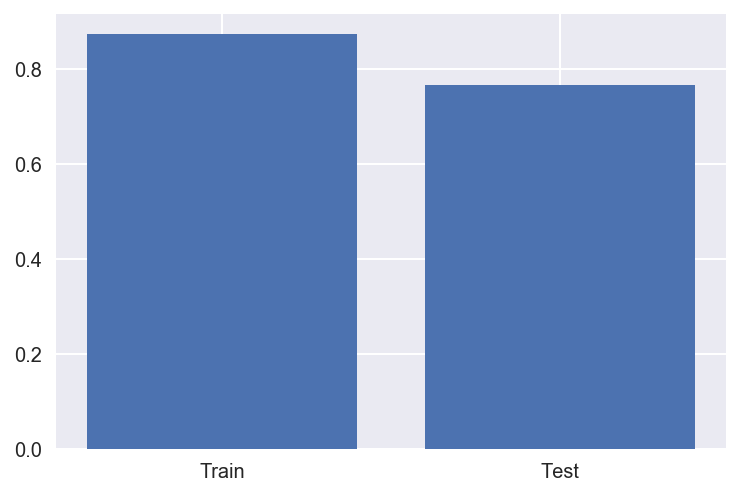

In [59]:
# def after_total_con():
model_edit = clf.fit(X_train, y_train)

y_pred = model_edit.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_T = model_edit.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_T)
plt.bar(x,y)
plt.show()

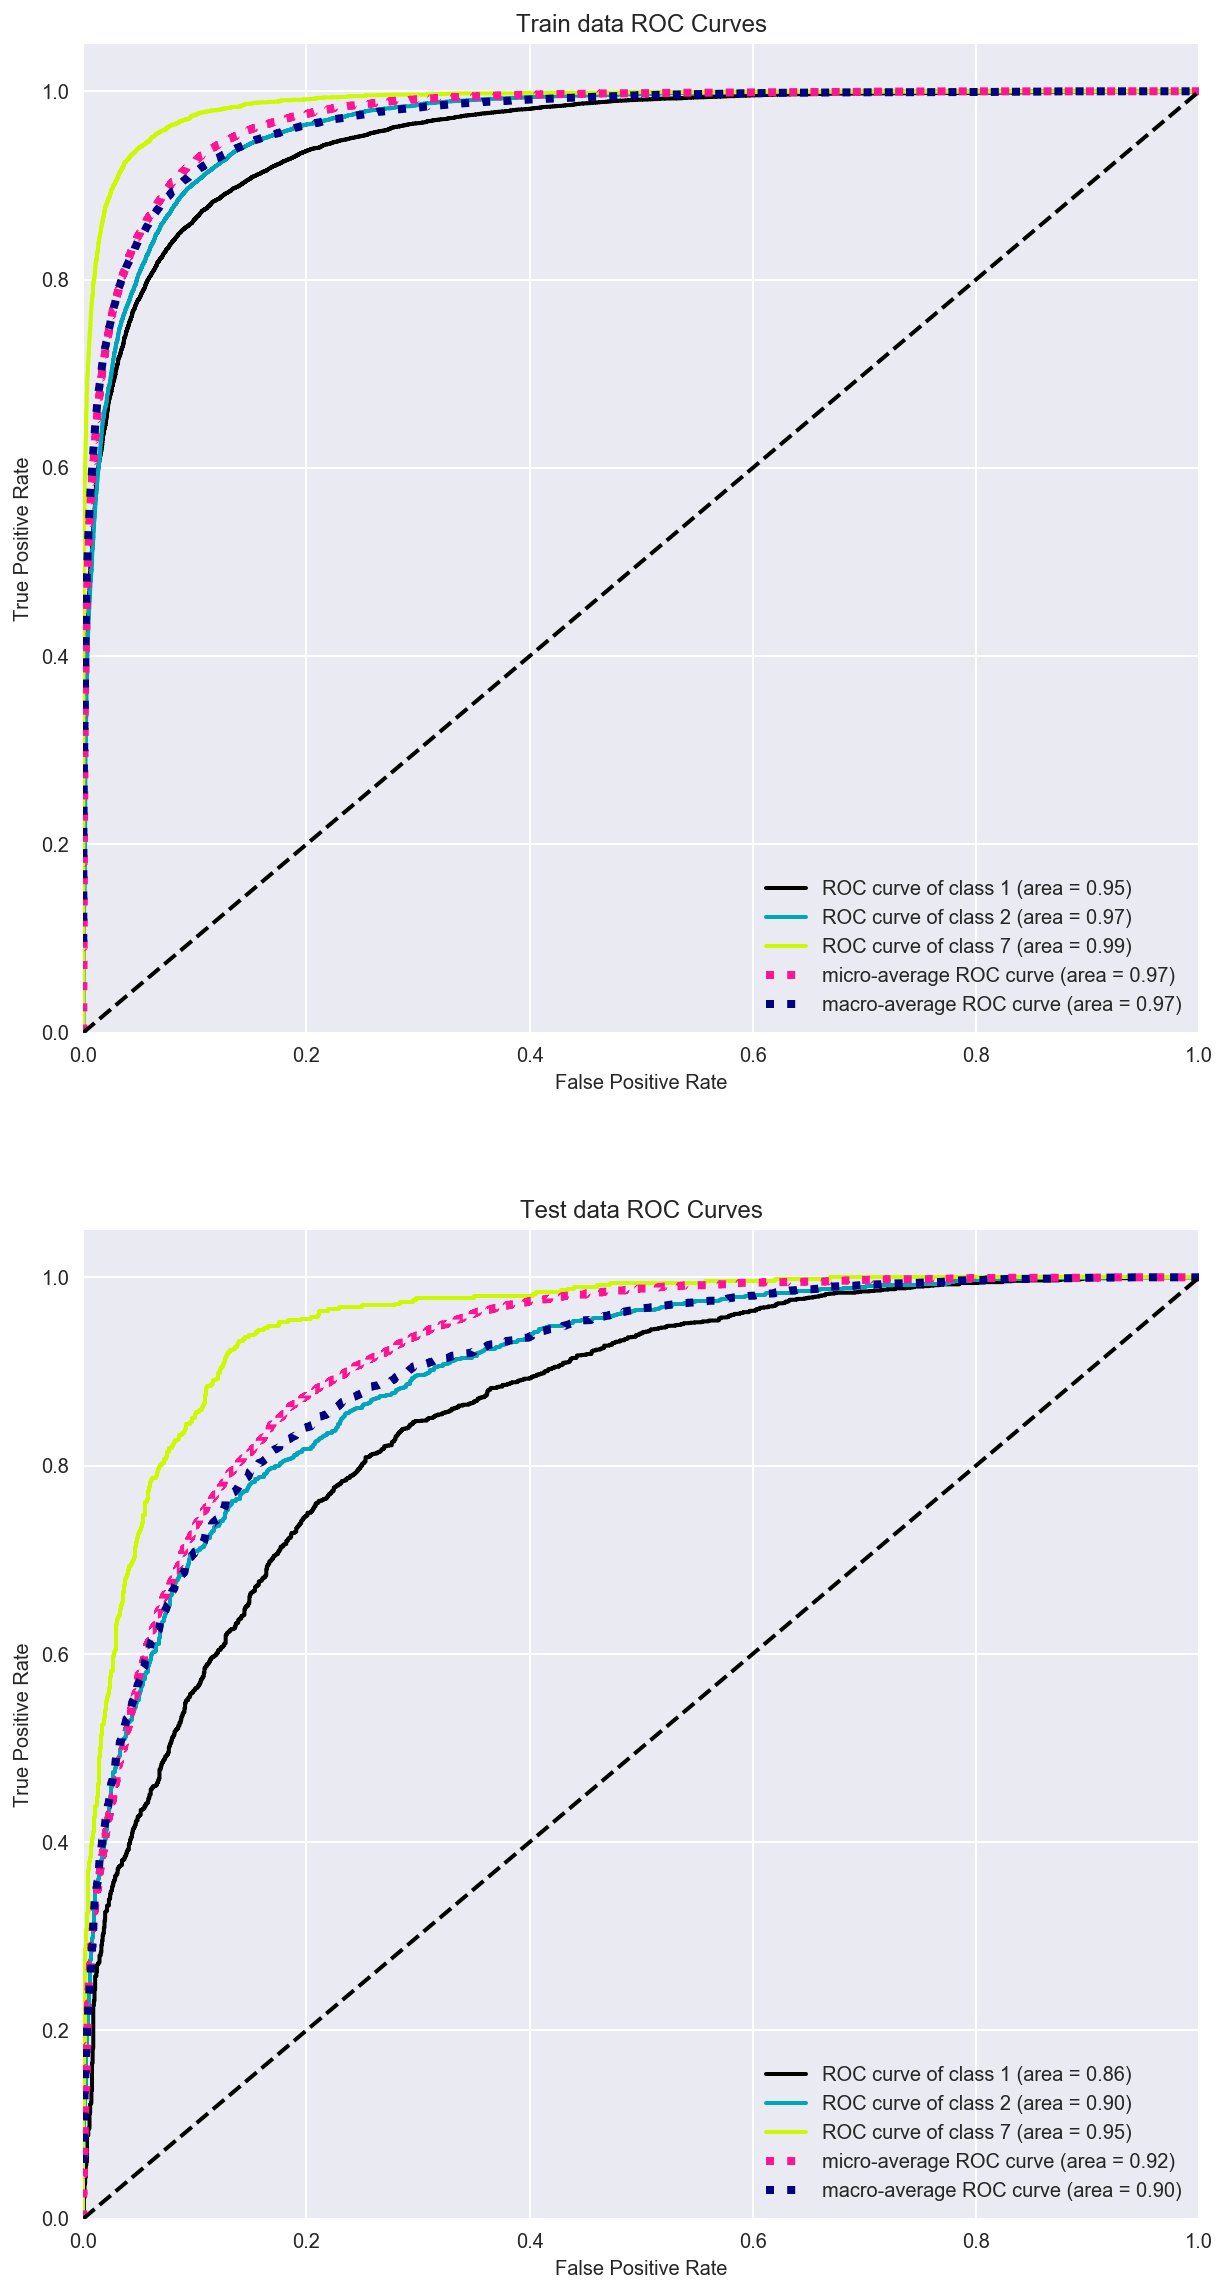

In [60]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_edit.predict_proba(X_train)
y_probas_T = model_edit.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test  (과학:1, 경제:2, 문화:7)

In [61]:
X_=pd.Series("개헌")

y_pred_t = model_edit.predict_proba(X_)
y_pred = model_edit.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.0259731  0.02554398 0.94848292]]
[7]


In [70]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_edit.predict_proba(X_)
y_pred = model_edit.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 도서관
[[0.26048722 0.05735087 0.68216191]]
[7]


### class 축소 진행 후 total 분석

In [72]:
def data_resetting():
    total_ = total_edit.filter(items=['본문',"class",'category'])
    total_ = total_.rename(columns={"본문":"contd"})
    total__ = total_edit.filter(items=['특성추출',"class",'category'])
    total__ = total__.rename(columns={"특성추출":"contd"})
    total___ = total_edit.filter(items=['제목',"class",'category'])
    total___ = total___.rename(columns={"제목":"contd"})
    total____ = total_edit.filter(items=['키워드정리',"class",'category'])
    total____ = total____.rename(columns={"키워드정리":"contd"})
    
    edit_total = pd.concat([total_,total__,total___,total____]).reset_index(drop=True)
    
    return edit_total

edit_total = data_resetting()

In [75]:
edit_total.tail()

,contd,class,category
156867,"국가,주제,대응,통계,이용자,인공지능,사물인터넷,황수경,메르디앙,통계발전,산업혁명,...",문화,7
156868,"2,,차이,경험,일환,3국,팻감,완벽,부분적,진재호,순간,하지만,유혹,대마,대국,수...",문화,7
156869,"뇌과학적,불필요,형상,누적,하버드,생리학,경험,독일,대응,지식,순간,기능적,박사,도...",문화,7
156870,"근대길,빌딩군,,눈길,건축인,마을,선포,1회,독일,www.saf.kr,종묘,로잔,집...",문화,7
156871,"눈길,엘리멘츠,M에이트리움,경험,무료,전시관,가든,미디어,방문,정원,미드,셰프팔레트...",문화,7


In [76]:
X_train, X_test, y_train, y_test = train_test_split(edit_total['contd'], edit_total['category'], \
                                                    test_size=0.1, random_state=0)

len(X_train),len(X_test),len(y_train),len(y_test)

(141184, 15688, 141184, 15688)

Train 

Train confusion_matrix 

[[70547  4483  2007]
 [11935 34217   298]
 [ 3247   277 14173]] 


Train classification_report 

             precision    recall  f1-score   support

          1       0.82      0.92      0.87     77037
          2       0.88      0.74      0.80     46450
          7       0.86      0.80      0.83     17697

avg / total       0.85      0.84      0.84    141184
 


Train accuracy_score 

0.84 




Test 

Test confusion_matrix 

[[7627  643  281]
 [1580 3480   38]
 [ 518   36 1485]] 


Test classification_report 

             precision    recall  f1-score   support

          1       0.78      0.89      0.83      8551
          2       0.84      0.68      0.75      5098
          7       0.82      0.73      0.77      2039

avg / total       0.81      0.80      0.80     15688
 


Test accuracy_score 

0.8 




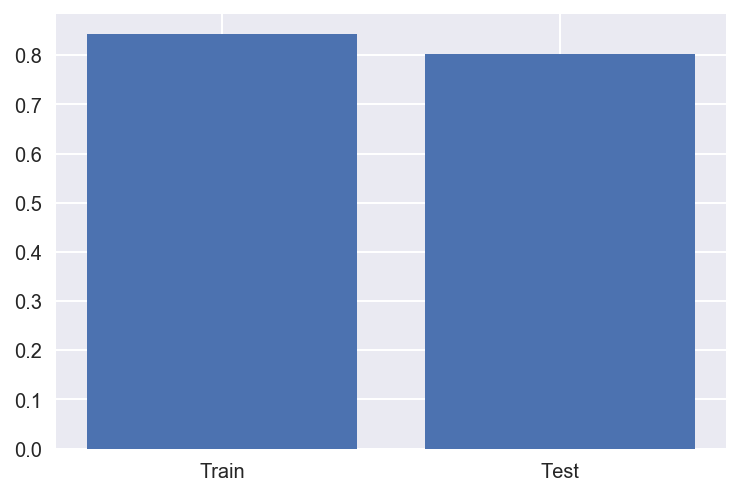

In [77]:
# def after_total_con():
model_edit_t = clf.fit(X_train, y_train)

y_pred = model_edit_t.predict(X_train)

print("Train", "\n")
print("Train confusion_matrix", "\n")
print(confusion_matrix(y_train, y_pred), "\n\n")
print("Train classification_report", "\n")
print(classification_report(y_train, y_pred), "\n\n")
print("Train accuracy_score", "\n")
print(round(accuracy_score(y_train, y_pred), 2), "\n\n")

print("=====================================================" , "\n\n")

y_pred_T = model_edit_t.predict(X_test)

print("Test", "\n")
print("Test confusion_matrix", "\n")
print(confusion_matrix(y_test, y_pred_T), "\n\n")
print("Test classification_report", "\n")
print(classification_report(y_test, y_pred_T), "\n\n")
print("Test accuracy_score", "\n")
print(round(accuracy_score(y_test, y_pred_T), 2), "\n\n")

x="Train","Test"
y=accuracy_score(y_train, y_pred), accuracy_score(y_test, y_pred_T)
plt.bar(x,y)
plt.show()

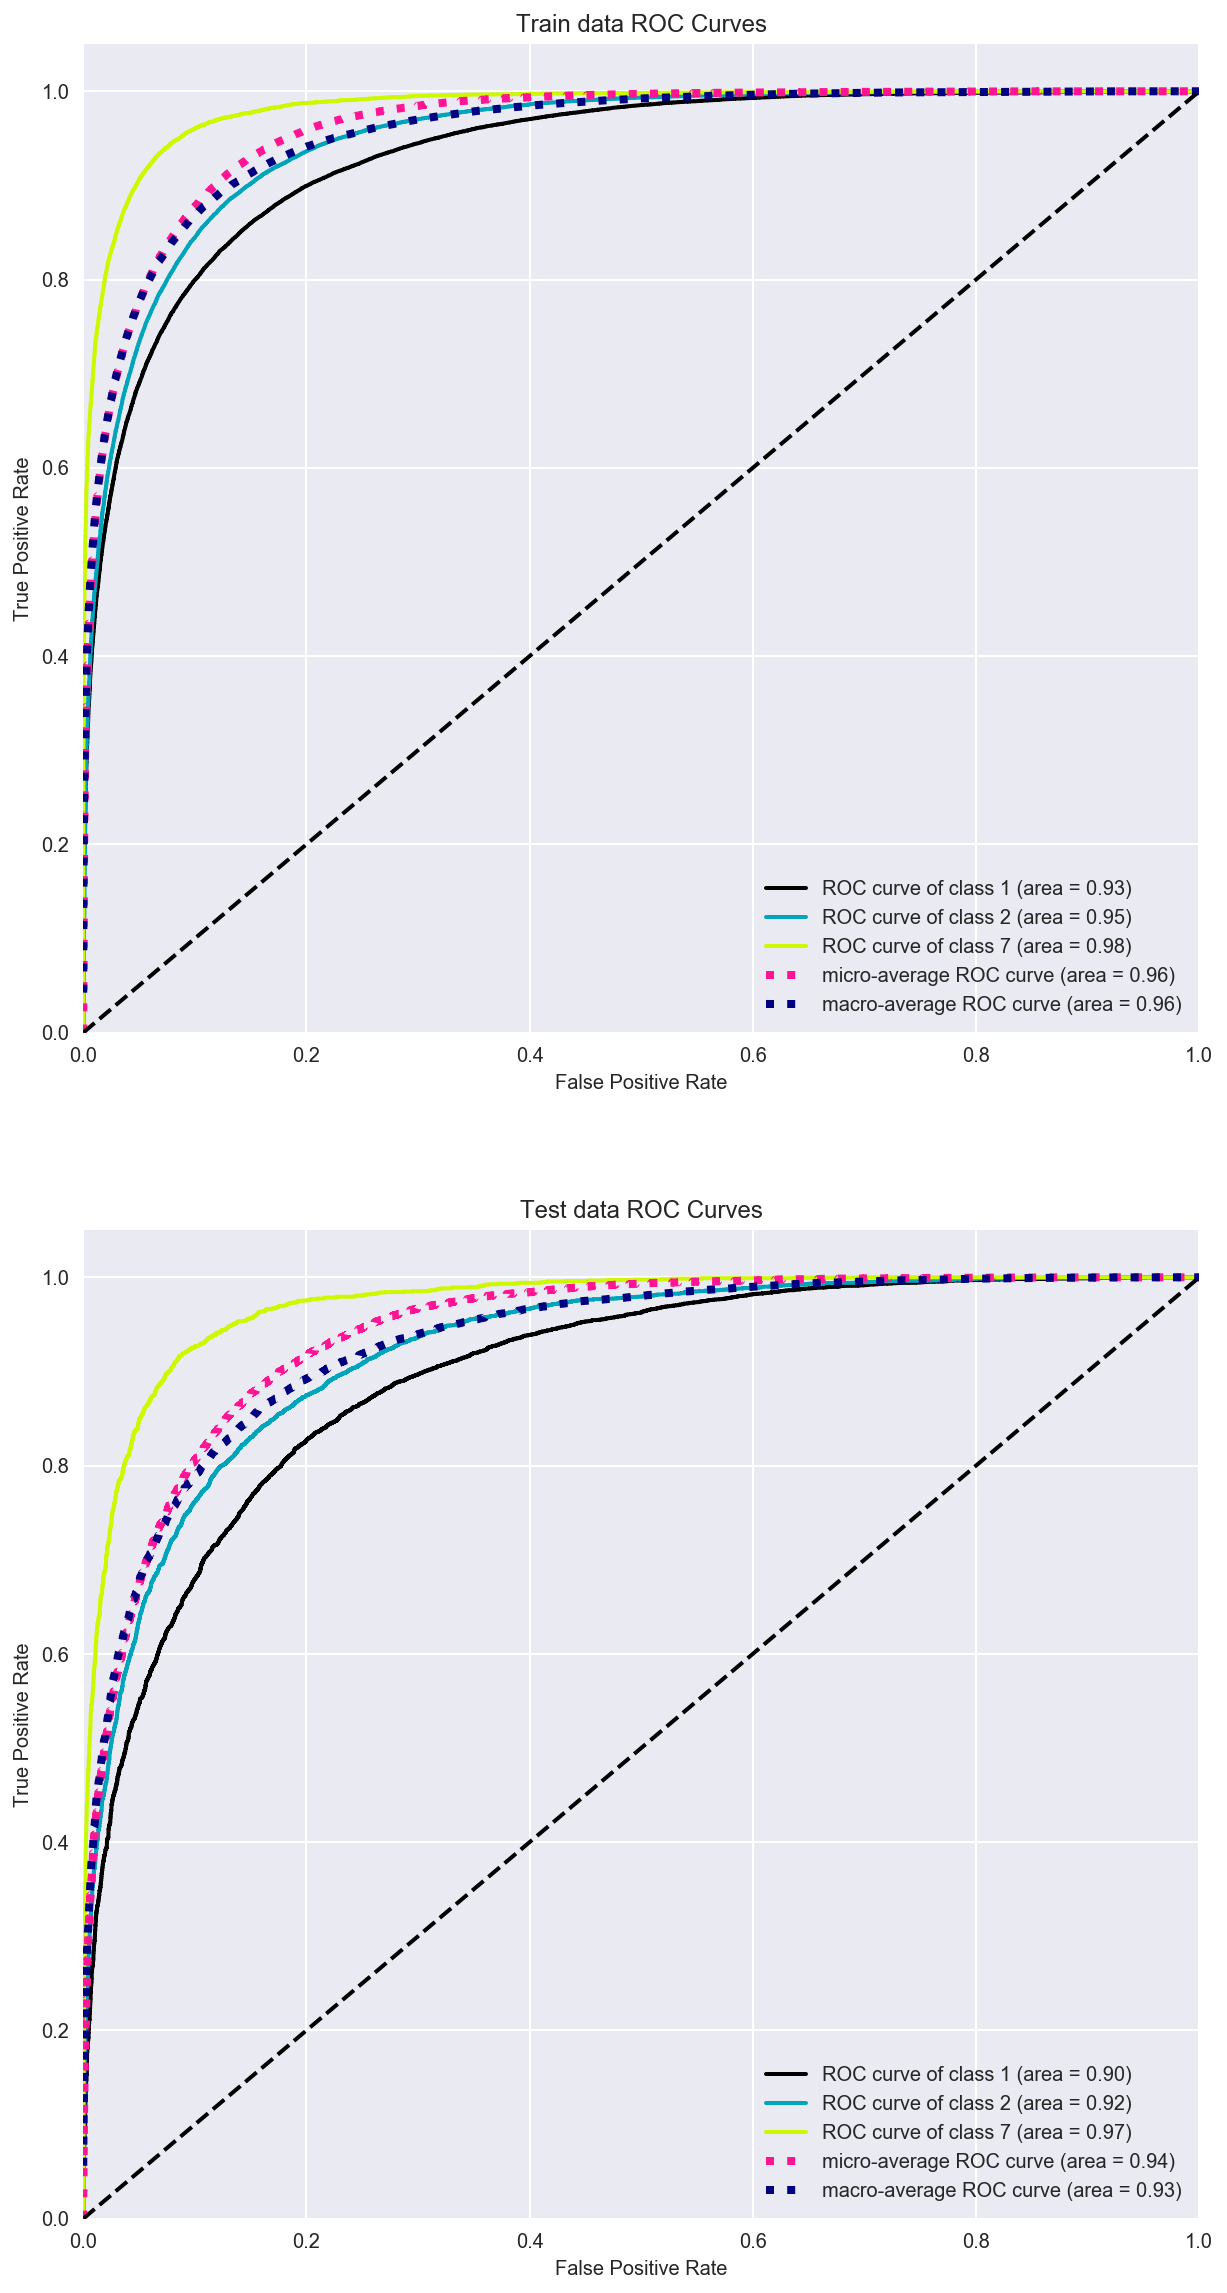

In [78]:
import scikitplot as skplt

fig = plt.figure(figsize=(10, 20))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

y_probas = model_edit_t.predict_proba(X_train)
y_probas_T = model_edit_t.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_train, y_probas, ax=ax1, title='Train data ROC Curves')

skplt.metrics.plot_roc_curve(y_test, y_probas_T, ax=ax2, title='Test data ROC Curves')

plt.show()

### 문구 Test  (과학:1, 경제:2, 문화:7)

In [80]:
X_=pd.Series("헌법")

y_pred_t = model_edit.predict_proba(X_)
y_pred = model_edit.predict(X_)

print(y_pred_t)
print(y_pred)

[[0.44971214 0.15074974 0.39953812]]
[1]


In [111]:
X_=pd.Series(str(input("insert 1number : ")))

y_pred_t = model_edit.predict_proba(X_)
y_pred = model_edit.predict(X_)

print(y_pred_t)
print(y_pred)

insert 1number : 마을
[[0.40382645 0.11822203 0.47795152]]
[7]


---